<a href="https://colab.research.google.com/github/gayecolakoglu/DiabeticRetinopathyDetection/blob/main/Bayesian_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pathlib
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
#https://medium.com/@pierre.beaujuge/bayesian-optimization-on-the-head-classifier-of-pre-trained-cnns-using-the-cifar10-dataset-48c440b67b2c
# Install GPy, GPyOpt
!pip install tensorflow-addons
!pip install GPy==1.9.8
!pip install GPyOpt==1.2.1
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 5.0 MB/s 
     |████████████████████████████████| 71 kB 8.4 MB/s 
  Created wheel for GPy: filename=GPy-1.9.8-cp37-cp37m-linux_x86_64.whl size=2619387 sha256=14284401a3ea1ca91cdd2da493a8bba694630ec28f32e7a6e0786924faf257a9
  Stored in directory: /root/.cache/pip/wheels/23/6d/58/90d8e44f8fd9f442de81992a427a5947a6e5f7b78cd65acd9a
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102566 sha256=56041c0e8b16145d77c74747aaed54ce825203127b6b20b1e7485afbde6380f9
  Stored in directory: /root/.cache/pip/wheels/c8/95/f5/ce28482da28162e6028c4b3a32c41d147395825b3cd62bc810
Successfully built GPy paramz
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-whe

In [ ]:
!pip install split-folders
import splitfolders
splitfolders.ratio('/content/gdrive/MyDrive/allDataCLAHE', output="output", seed=1337, ratio=(.7, 0.2, 0.1)) #train,val,test

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 11586 files [04:30, 42.80 files/s] 


In [ ]:
#https://stackoverflow.com/questions/55674648/how-to-load-local-dataset-x-y-using-keras-framework
!pip install image-dataset-loader
from image_dataset_loader import load

(x_train, y_train), (x_test, y_test) = load('/content/output/', ['train', 'val']) # Görselleri dataframe'e yazar target'la birlikte. Görselleri array olarak tutar.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Görselleri normalize eder (x = x / 255) targetlara da one hot encoding yapar (1,0,0)
def preprocess_data(X, Y):
    """
    function that pre-processes the DR dataset as per
    densenet model requirements for input images
    labels are one-hot encoded
    """
    X = tf.keras.applications.vgg16.preprocess_input(X)
    Y = K.utils.to_categorical(Y)
    return X, Y

In [ ]:
# preprocess the data using the application's preprocess_input method and convert the labels to one-hot encodings
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense,Flatten,Conv2D,Activation,Dropout

input_tensor = K.Input(shape=(32, 32, 3)) # Input olarak girecek yapıyı oluşturur
# resize images to the image size upon which the network was pre-trained
resized_images = K.layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(input_tensor) # lambda list comp. gibi input_tensordaki tüm image'ı resize ediyor
base_model = VGG16(include_top=False,
                    weights='imagenet',
                    input_tensor=resized_images,
                    input_shape=(224, 224, 3),
                    pooling='max',
                    classes=5)

output = base_model.layers[-1].output
base_model = K.models.Model(inputs=input_tensor, outputs=output)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
# using the training data
train_datagen = K.preprocessing.image.ImageDataGenerator()# no data augmentation for train set we did that in seperate code for class 1,3 and 4
      
train_generator = train_datagen.flow(x_train,
                                     y_train,
                                     batch_size=32,
                                     shuffle=False)
features_train = base_model.predict(train_generator)
# repeat the same operation with the test data (here used for validation)
val_datagen = K.preprocessing.image.ImageDataGenerator()  # no augmentation for validation set
val_generator = val_datagen.flow(x_test,
                                 y_test,
                                 batch_size=32,
                                 shuffle=False)
features_valid = base_model.predict(val_generator)

In [ ]:
'''
from keras import backend

def recall_m(y_true, y_pred):
    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = backend.sum(backend.round(backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + backend.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = backend.sum(backend.round(backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + backend.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+backend.epsilon()))
'''

In [ ]:
from tensorflow.keras import layers, models
from keras.models import Sequential, Model

def build_model(units=256, learning_rate=1e-4, l2=1e-2, activation=2, rate=0.5, batch = 32, optim=1):
  """function that builds a model for the head classifier"""
  # weights are initialized as per the he et al. method
  initializer = K.initializers.he_normal()
  input_tensor = K.Input(shape=features_train.shape[1])
  activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh'}
  optimizer_dict = {1: 'Adam', 2: 'SGD', 3: 'RMSprop'}
  layer = K.layers.Dense(units=units,
                         activation=activation_dict[activation],
                         kernel_initializer=initializer,
                        kernel_regularizer=K.regularizers.l2(l2=l2))
  output = layer(input_tensor)
  dropout = K.layers.Dropout(rate)
  output = dropout(output)
  softmax = K.layers.Dense(units=5,
                           activation='softmax',
                           kernel_initializer=initializer,
                        kernel_regularizer=K.regularizers.l2(l2=l2))
  output = softmax(output)
  model = K.models.Model(inputs=input_tensor, outputs=output)
  # compile the densely-connected head classifier (here, "model")
  if optim==1:
    model.compile(
            optimizer=K.optimizers.Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=["accuracy"])
  elif optim==2:
    model.compile(
            optimizer=K.optimizers.SGD(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=["accuracy"])
  elif optim==3:
    model.compile(
            optimizer=K.optimizers.RMSprop(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=["accuracy"])
  else:
    print("Wrong optimizer!!")
  # Define some callback functions to be used by the model during training
  # reduce learning rate when val_accuracy has stopped improving
  lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            factor=0.6,
                                            patience=2,
                                            verbose=1,
                                            mode='max',
                                            min_lr=1e-7)
  # stop training when val_accuracy has stopped improving
  early_stop = K.callbacks.EarlyStopping(monitor='val_accuracy',
                                         patience=3,
                                         verbose=1,
                                         mode='max')
  # callback to save the Keras model and (best) weights obtained on an epoch basis
  checkpoint = K.callbacks.ModelCheckpoint('VGG_16.h5',
                                           monitor='val_accuracy',
                                           verbose=1,
                                           save_weights_only=False,
                                           save_best_only=True,
                                           mode='max',
                                           save_freq='epoch')
  return model, lr_reduce, early_stop, checkpoint, batch

In [ ]:
def fit_model(model, lr_reduce, early_stop, checkpoint, batch):
  """function that trains the head classifier"""
  history = model.fit(features_train, y_train,
                      batch_size=batch,
                      epochs=100,
                      verbose=0,
                      callbacks=[lr_reduce, early_stop, checkpoint],
                      validation_data=(features_valid, y_test),
                      shuffle=True)
  return history

In [ ]:
def evaluate_model(model):
  """function that evaluates the head classifier"""
  evaluation = model.evaluate(features_valid, y_test)
  return evaluation


Hyperparameters: [[6.4e+01 1.0e-04 1.0e-02 1.0e+00 7.0e-01 3.2e+01 1.0e+00]]

Epoch 1: val_accuracy improved from -inf to 0.41814, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.41814 to 0.49330, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.49330 to 0.52354, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.52354 to 0.53650, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.53650 to 0.53866, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.53866 to 0.54384, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.54384 to 0.54428, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.54428 to 0.54471, saving model to VGG_16.h5

Epoch 9: val_accuracy did not improve from 0.54471

Epoch 10: val_accuracy improved from 0.54471 to 0.54514, saving model to VGG_16.h5

Epoch 11: val_accuracy did not improve from 0.54514

Epoch 12: ReduceLROnPlateau reducing learning rate to 5.999999848427251

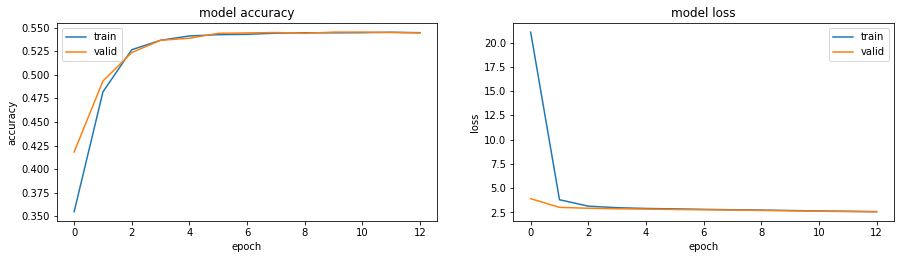


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-03 3.00e+00 3.00e-01 2.56e+02 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.28639, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.28639 to 0.34644, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.34644 to 0.40734, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.40734 to 0.45011, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.45011 to 0.47300, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.47300 to 0.48683, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.48683 to 0.49330, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.49330 to 0.50238, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.50238 to 0.50497, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.50497 to 0.51058, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.51058 to 0.51577, saving model to VGG_16.h5

Ep

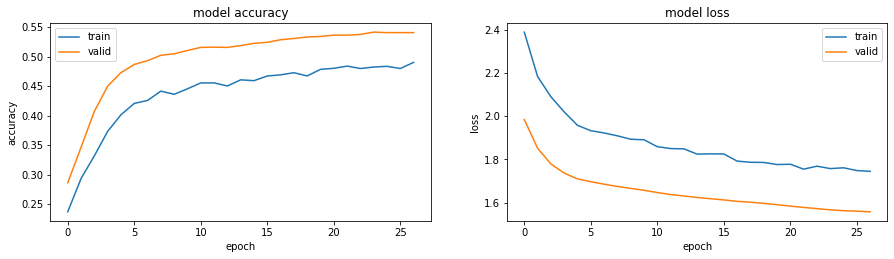


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-03 2.00e+00 5.00e-01 1.28e+02 1.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.19698, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.19698 to 0.24752, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.24752 to 0.35421, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.35421 to 0.41771, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.41771 to 0.44449, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.44449 to 0.45702, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.45702 to 0.46782, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.46782 to 0.47646, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.47646 to 0.48251, saving model to VGG_16.h5

Epoch 10: val_accuracy did not improve from 0.48251

Epoch 11: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 11: val_accuracy did not improve 

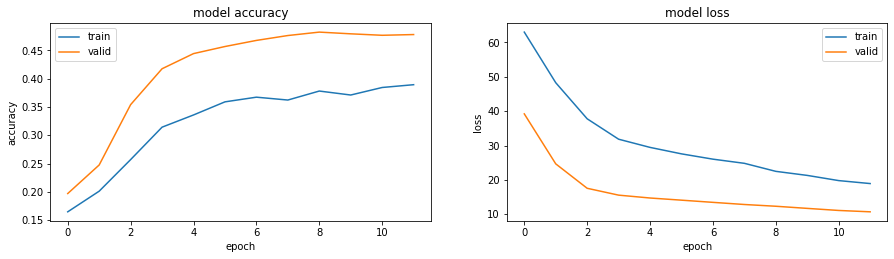


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-03 1.00e+00 5.00e-01 1.28e+02 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.55378, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.55378 to 0.55594, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.55594

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.55594

Epoch 5: val_accuracy did not improve from 0.55594
Epoch 5: early stopping
73/73 [==============================] - 0s 2ms/step - loss: 1.4760 - accuracy: 0.5529 - precision_m: 0.6071 - recall_m: 0.4121 - f1_m: 0.4889

LOSS:	1.4759963750839233 	 ACCURACY:	0.5529157519340515 	 PRECISION:	0.6071455478668213 	 RECALL:	0.41212642192840576 	 F1-SCORE:	0.48889562487602234
[1.4759963750839233, 0.5529157519340515, 0.6071455478668213, 0.41212642192840576, 0.48889562487602234]



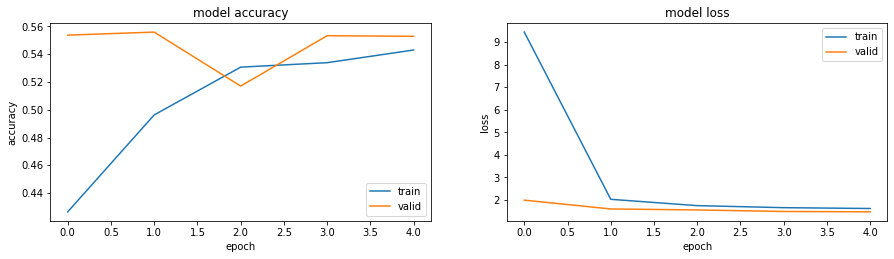


Hyperparameters: [[6.40e+01 1.00e-03 1.00e-02 3.00e+00 3.00e-01 2.56e+02 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.49114, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.49114 to 0.51015, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.51015 to 0.52484, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.52484

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.52484

Epoch 6: val_accuracy did not improve from 0.52484
Epoch 6: early stopping
73/73 [==============================] - 0s 2ms/step - loss: 2.7092 - accuracy: 0.5145 - precision_m: 0.5641 - recall_m: 0.4301 - f1_m: 0.4871

LOSS:	2.709230899810791 	 ACCURACY:	0.5144708156585693 	 PRECISION:	0.5641164779663086 	 RECALL:	0.43006694316864014 	 F1-SCORE:	0.4870680272579193
[2.709230899810791, 0.5144708156585693, 0.5641164779663086, 0.43006694316864014, 0.4870680272579193]



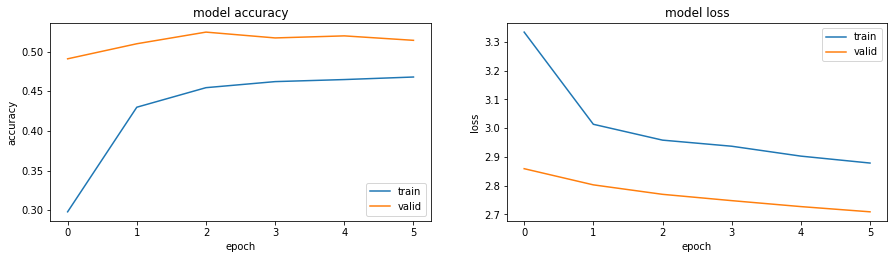




Hyperparameters: [[5.12e+02 1.00e-03 1.00e-01 3.00e+00 5.00e-01 3.20e+01 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.58445, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.58445 to 0.60259, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.60259 to 0.60950, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.60950 to 0.61857, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.61857 to 0.62678, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.62678 to 0.62851, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.62851 to 0.63629, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.63629

Epoch 9: val_accuracy improved from 0.63629 to 0.63758, saving model to VGG_16.h5

Epoch 10: val_accuracy did not improve from 0.63758

Epoch 11: val_accuracy improved from 0.63758 to 0.63974, saving model to VGG_16.h5

Epoch 12: val_accuracy did not improve from 0.63974

Epoch 13:

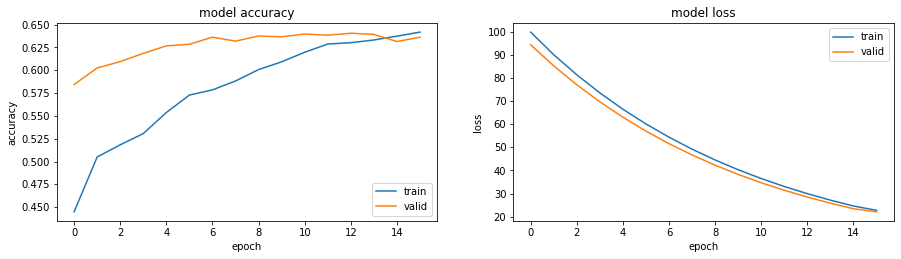


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-01 1.00e+00 5.00e-01 1.28e+02 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.23413, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.23413 to 0.45227, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.45227 to 0.49071, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.49071 to 0.51102, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.51102 to 0.51749, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.51749 to 0.52397, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.52397 to 0.53391, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.53391 to 0.53909, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.53909 to 0.54428, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.54428 to 0.55248, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.55248 to 0.55637, saving model to VGG_16.h5

Ep

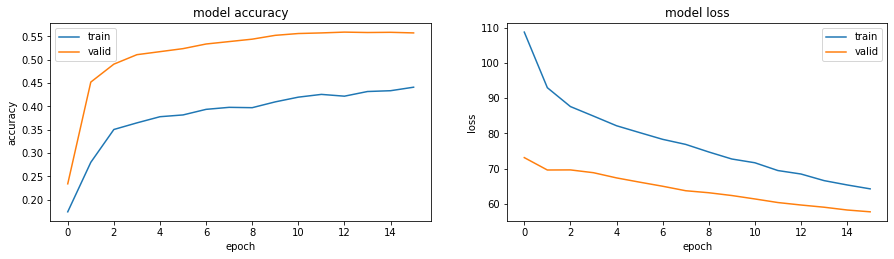


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-01 1.00e+00 7.00e-01 1.28e+02 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.55076, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.55076 to 0.58229, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.58229 to 0.58618, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.58618 to 0.59870, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.59870

Epoch 6: val_accuracy improved from 0.59870 to 0.60302, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.60302

Epoch 8: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 8: val_accuracy did not improve from 0.60302

Epoch 9: val_accuracy did not improve from 0.60302
Epoch 9: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 104.9052 - accuracy: 0.5909 - precision_m: 0.5905 - recall_m: 0.5880 - f1_m: 0.5892

LOSS:	104.90518188476562 	 ACCURACY:	0.590928733

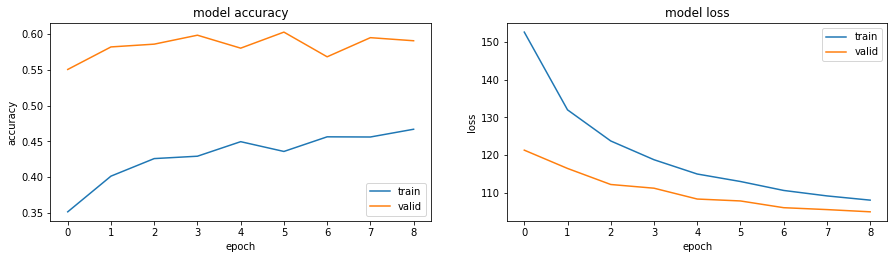


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-03 3.00e+00 7.00e-01 1.28e+02 1.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.08812, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.08812 to 0.09158, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.09158 to 0.09935, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.09935 to 0.10756, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.10756 to 0.11361, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.11361 to 0.12441, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.12441 to 0.14168, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.14168 to 0.15594, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.15594 to 0.17624, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.17624 to 0.19698, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.19698 to 0.21814, saving model to VGG_16.h5

Ep

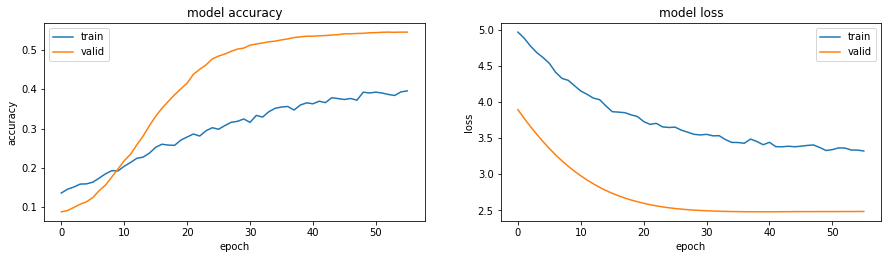


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-02 2.00e+00 5.00e-01 3.20e+01 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.18963, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.18963 to 0.29719, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.29719 to 0.39006, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.39006 to 0.42981, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.42981 to 0.44752, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.44752 to 0.45745, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.45745 to 0.46652, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.46652 to 0.46825, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.46825 to 0.47127, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.47127 to 0.47473, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.47473 to 0.48164, saving model to VGG_16.h5

Ep

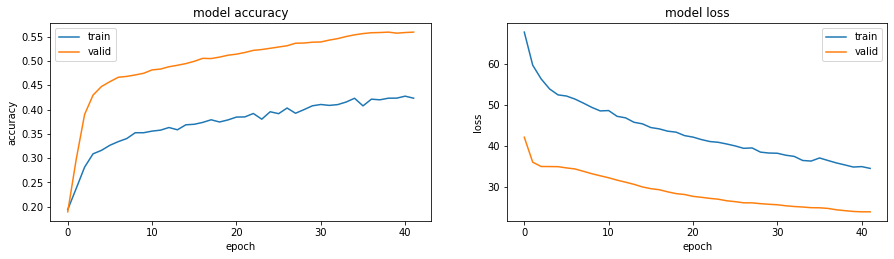


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-02 3.00e+00 5.00e-01 2.56e+02 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.22333, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.22333 to 0.23369, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.23369 to 0.25097, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.25097 to 0.26350, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.26350 to 0.27646, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.27646 to 0.28683, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.28683 to 0.29806, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.29806 to 0.31188, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.31188 to 0.32311, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.32311 to 0.33305, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.33305 to 0.34644, saving model to VGG_16.h5

Ep

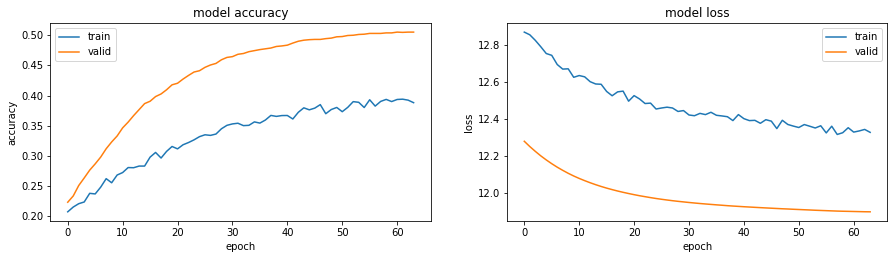


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-03 1.00e+00 5.00e-01 1.28e+02 1.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.55767, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.55767 to 0.60086, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.60086 to 0.61901, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.61901 to 0.61944, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.61944 to 0.62333, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.62333 to 0.62937, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.62937

Epoch 8: val_accuracy improved from 0.62937 to 0.63844, saving model to VGG_16.h5

Epoch 9: val_accuracy did not improve from 0.63844

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 10: val_accuracy did not improve from 0.63844

Epoch 11: val_accuracy did not improve from 0.63844
Epoch 11: early stopping
73/73 [=================

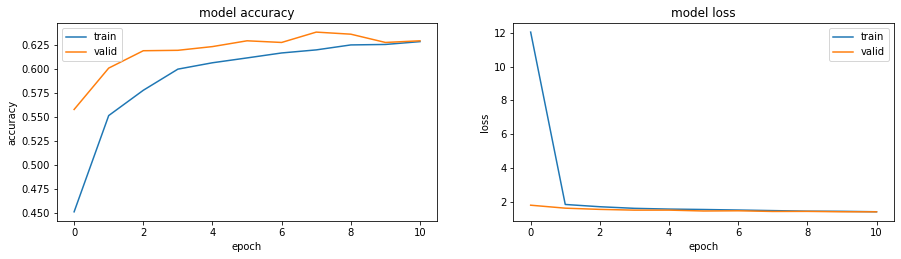


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-03 1.00e+00 7.00e-01 1.28e+02 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.43629, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.43629 to 0.52613, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.52613 to 0.53650, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.53650 to 0.54255, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.54255 to 0.54298, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.54298 to 0.54860, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.54860 to 0.55076, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.55076 to 0.55464, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.55464 to 0.56026, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.56026 to 0.56631, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.56631 to 0.57408, saving model to VGG_16.h5

Ep

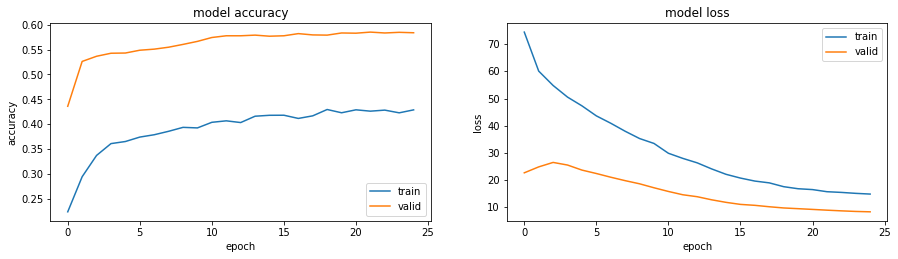


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-02 2.00e+00 7.00e-01 3.20e+01 1.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.46998, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.46998 to 0.53866, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.53866 to 0.54644, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.54644 to 0.55378, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.55378 to 0.55940, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.55940 to 0.57106, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.57106 to 0.57451, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.57451 to 0.58099, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.58099 to 0.58143, saving model to VGG_16.h5

Epoch 10: val_accuracy did not improve from 0.58143

Epoch 11: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 11: val_accuracy did not improve 

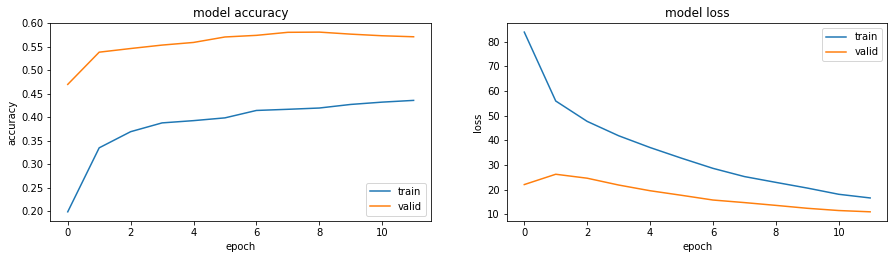


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-01 2.00e+00 7.00e-01 1.28e+02 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.58143, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.58143 to 0.60950, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.60950

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.60950

Epoch 5: val_accuracy improved from 0.60950 to 0.63283, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.63283 to 0.63499, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.63499 to 0.64233, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.64233

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 9: val_accuracy did not improve from 0.64233

Epoch 10: val_accuracy improved from 0.64233 to 0.64276, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.64276 to 0.64579,

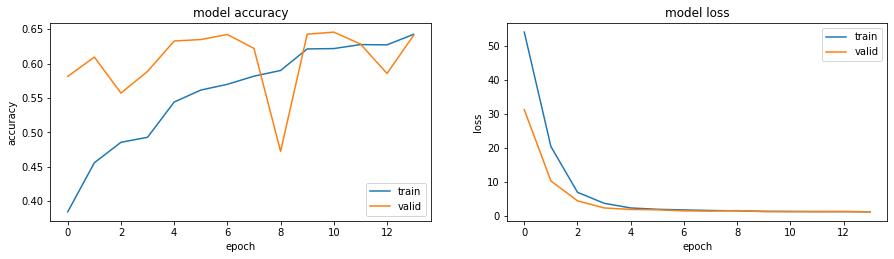


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-03 2.00e+00 5.00e-01 2.56e+02 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.54298, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.54298 to 0.59395, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.59395

Epoch 4: val_accuracy improved from 0.59395 to 0.61901, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.61901

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 6: val_accuracy did not improve from 0.61901

Epoch 7: val_accuracy improved from 0.61901 to 0.62419, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.62419

Epoch 9: val_accuracy improved from 0.62419 to 0.63413, saving model to VGG_16.h5

Epoch 10: val_accuracy did not improve from 0.63413

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 11: val_accuracy did not improve from 0.63413

Epoch 12: val_accuracy did not im

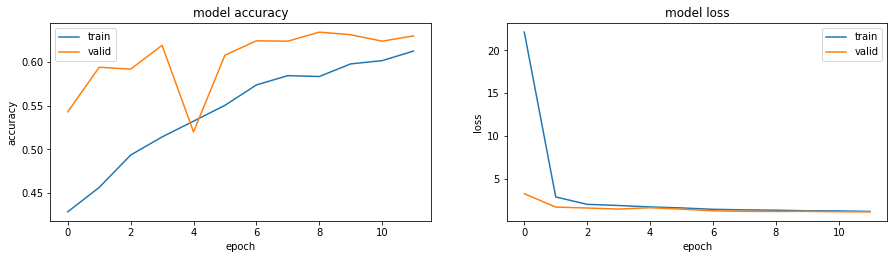


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-01 3.00e+00 7.00e-01 2.56e+02 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.32441, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.32441 to 0.32527, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.32527 to 0.32700, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.32700

Epoch 5: val_accuracy improved from 0.32700 to 0.32743, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.32743 to 0.32959, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.32959 to 0.33002, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.33002 to 0.33045, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.33045 to 0.33218, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.33218 to 0.33261, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.33261 to 0.33434, saving model to VGG_16.h5

Epoch 12: val_accuracy improved f

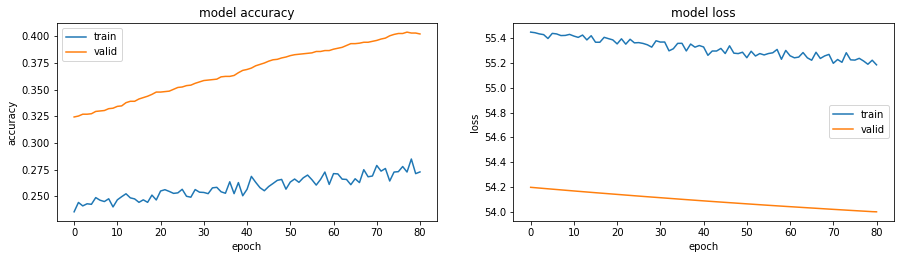


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-03 3.00e+00 5.00e-01 1.28e+02 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.36285, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.36285 to 0.37667, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.37667 to 0.38704, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.38704 to 0.39870, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.39870 to 0.40864, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.40864 to 0.42073, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.42073 to 0.42765, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.42765 to 0.43456, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.43456 to 0.43931, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.43931 to 0.44752, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.44752 to 0.45616, saving model to VGG_16.h5

Ep

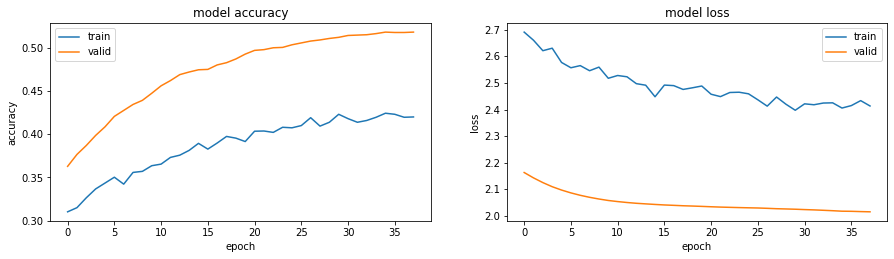


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-01 1.00e+00 3.00e-01 3.20e+01 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.20043, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.20043 to 0.35896, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.35896 to 0.45486, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.45486 to 0.47430, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.47430 to 0.49071, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.49071 to 0.49201, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.49201 to 0.49978, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.49978 to 0.50454, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.50454 to 0.50756, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.50756 to 0.51317, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.51317 to 0.51706, saving model to VGG_16.h5

Ep

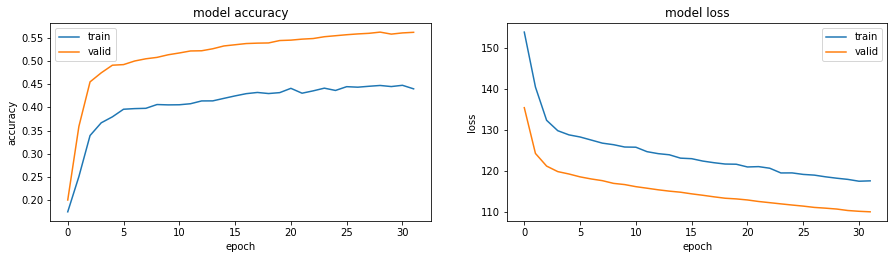


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-02 1.00e+00 7.00e-01 2.56e+02 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.09287, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.09287 to 0.12873, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.12873 to 0.18143, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.18143 to 0.23844, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.23844 to 0.30238, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.30238 to 0.36242, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.36242 to 0.40518, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.40518 to 0.44190, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.44190 to 0.46523, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.46523 to 0.48596, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.48596 to 0.49590, saving model to VGG_16.h5

Ep

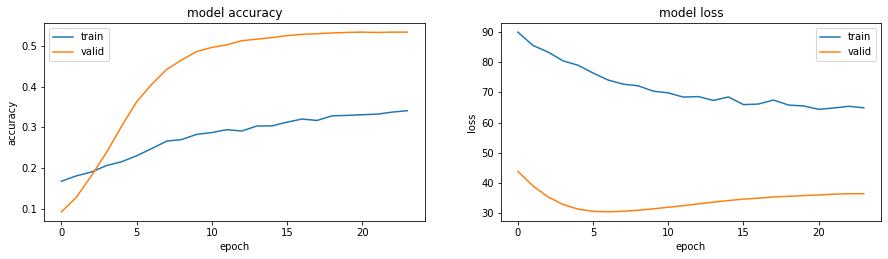


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-03 3.00e+00 5.00e-01 3.20e+01 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.42505, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.42505 to 0.51102, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.51102 to 0.52959, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.52959 to 0.53521, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.53521 to 0.54082, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.54082 to 0.54860, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.54860 to 0.55292, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.55292 to 0.55637, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.55637 to 0.55853, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.55853 to 0.56199, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.56199 to 0.57019, saving model to VGG_16.h5

Ep

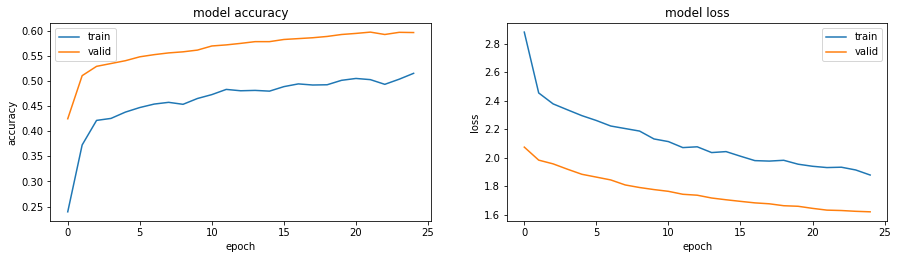


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-03 1.00e+00 3.00e-01 3.20e+01 1.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.54428, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.54428 to 0.55335, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.55335

Epoch 4: val_accuracy improved from 0.55335 to 0.55421, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.55421 to 0.58186, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.58186 to 0.59870, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.59870 to 0.60778, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.60778 to 0.61037, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.61037 to 0.61425, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.61425 to 0.62030, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.62030 to 0.62333, saving model to VGG_16.h5

Epoch 12: val_accuracy improved f

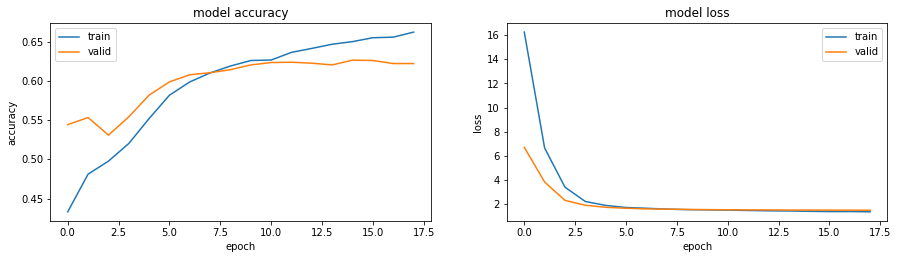


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-01 1.00e+00 7.00e-01 3.20e+01 1.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.53996, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.53996 to 0.55205, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.55205 to 0.56328, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.56328 to 0.56933, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.56933 to 0.57192, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.57192 to 0.57970, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.57970 to 0.58013, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.58013 to 0.58359, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.58359 to 0.58790, saving model to VGG_16.h5

Epoch 10: val_accuracy did not improve from 0.58790

Epoch 11: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 11: val_accuracy did not improve 

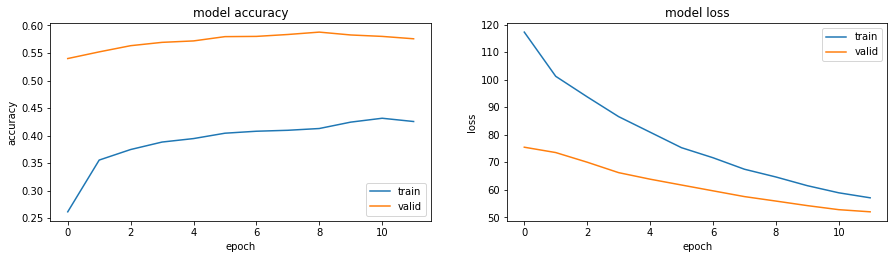


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-02 1.00e+00 3.00e-01 3.20e+01 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.31706, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.31706 to 0.47603, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.47603 to 0.50238, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.50238 to 0.50281, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.50281

Epoch 6: val_accuracy improved from 0.50281 to 0.51102, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.51102 to 0.51231, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.51231 to 0.51706, saving model to VGG_16.h5

Epoch 9: val_accuracy did not improve from 0.51706

Epoch 10: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 10: val_accuracy did not improve from 0.51706

Epoch 11: val_accuracy did not improve from 0.51706
Epoch 11: early stopping
73/73 [=================

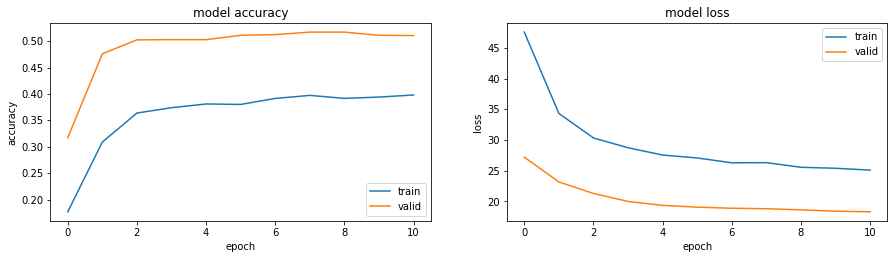


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-03 1.00e+00 5.00e-01 2.56e+02 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.52268, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.52268 to 0.58272, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.58272

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.58272

Epoch 5: val_accuracy did not improve from 0.58272
Epoch 5: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 1.9822 - accuracy: 0.5797 - precision_m: 0.5929 - recall_m: 0.5353 - f1_m: 0.5622

LOSS:	1.9822466373443604 	 ACCURACY:	0.5796976089477539 	 PRECISION:	0.5928643345832825 	 RECALL:	0.5352973341941833 	 F1-SCORE:	0.5622141361236572
[1.9822466373443604, 0.5796976089477539, 0.5928643345832825, 0.5352973341941833, 0.5622141361236572]



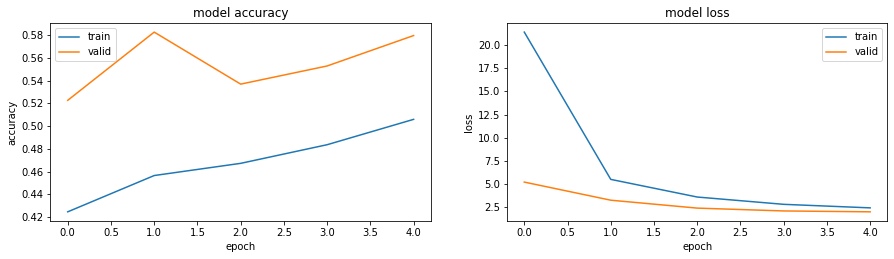


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-02 1.00e+00 7.00e-01 2.56e+02 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.57927, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.57927

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.57927

Epoch 4: val_accuracy did not improve from 0.57927
Epoch 4: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 6.5504 - accuracy: 0.5762 - precision_m: 0.5953 - recall_m: 0.5439 - f1_m: 0.5680

LOSS:	6.5503950119018555 	 ACCURACY:	0.5762419104576111 	 PRECISION:	0.5952694416046143 	 RECALL:	0.5438978672027588 	 F1-SCORE:	0.5680134892463684
[6.5503950119018555, 0.5762419104576111, 0.5952694416046143, 0.5438978672027588, 0.5680134892463684]



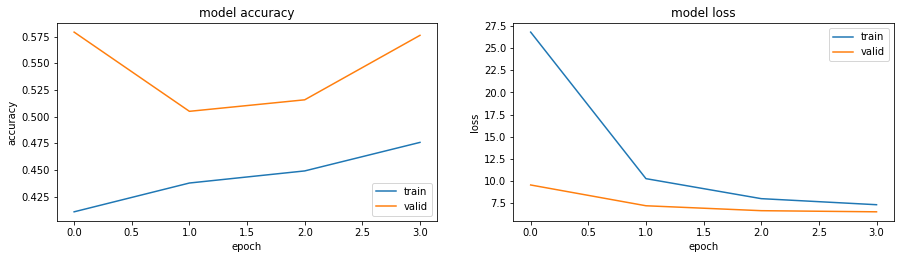


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-03 3.00e+00 5.00e-01 1.28e+02 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.35896, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.35896 to 0.46263, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.46263 to 0.50281, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.50281 to 0.51793, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.51793 to 0.52138, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.52138 to 0.52397, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.52397 to 0.52570, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.52570 to 0.53175, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.53175 to 0.53218, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.53218 to 0.53564, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.53564 to 0.53607, saving model to VGG_16.h5

Ep

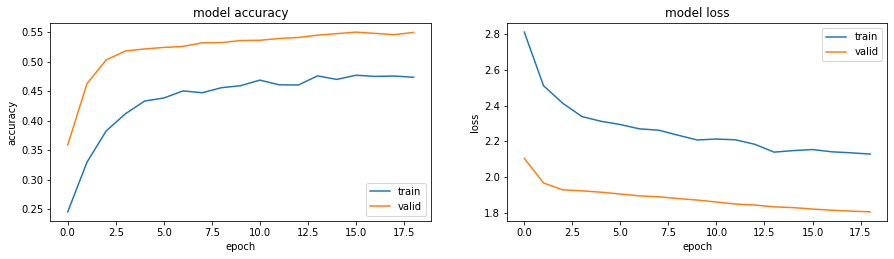


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-03 3.00e+00 3.00e-01 1.28e+02 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.13391, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.13391

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.13391

Epoch 4: val_accuracy did not improve from 0.13391
Epoch 4: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 3.3174 - accuracy: 0.1326 - precision_m: 0.1280 - recall_m: 0.0886 - f1_m: 0.1043

LOSS:	3.3174118995666504 	 ACCURACY:	0.1326133906841278 	 PRECISION:	0.1279502958059311 	 RECALL:	0.08857409656047821 	 F1-SCORE:	0.10434164851903915
[3.3174118995666504, 0.1326133906841278, 0.1279502958059311, 0.08857409656047821, 0.10434164851903915]



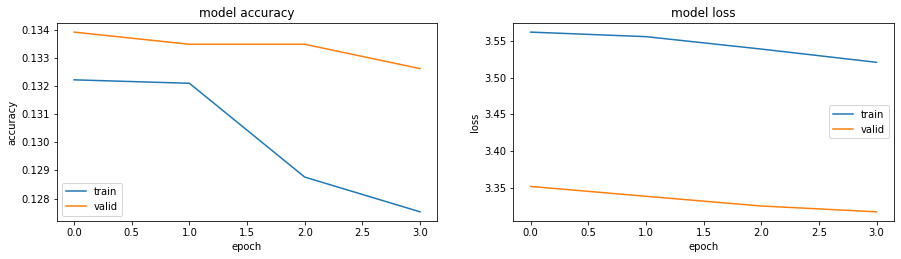


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 2.00e+00 3.00e-01 3.20e+01 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.47905, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.47905 to 0.55378, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.55378 to 0.56631, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.56631 to 0.57235, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.57235 to 0.60302, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.60302 to 0.62376, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.62376 to 0.62592, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.62592 to 0.62635, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.62635 to 0.63240, saving model to VGG_16.h5

Epoch 10: val_accuracy did not improve from 0.63240

Epoch 11: val_accuracy improved from 0.63240 to 0.63672, saving model to VGG_16.h5

Epoch 12: val_accuracy did not im

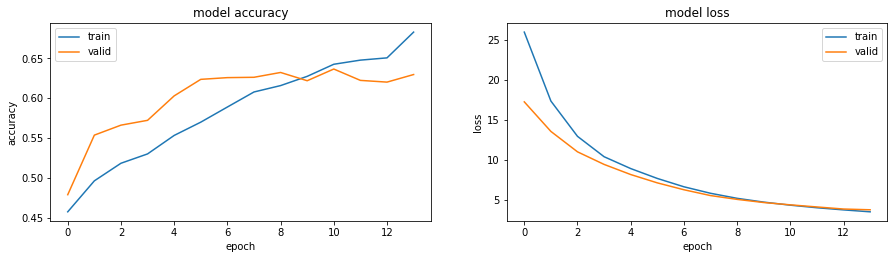


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-03 2.00e+00 5.00e-01 2.56e+02 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.45659, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.45659 to 0.55032, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.55032

Epoch 4: val_accuracy improved from 0.55032 to 0.57624, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.57624 to 0.57927, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.57927 to 0.58575, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.58575

Epoch 8: val_accuracy improved from 0.58575 to 0.59784, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.59784 to 0.60821, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.60821 to 0.61166, saving model to VGG_16.h5

Epoch 11: val_accuracy did not improve from 0.61166

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 12: val_acc

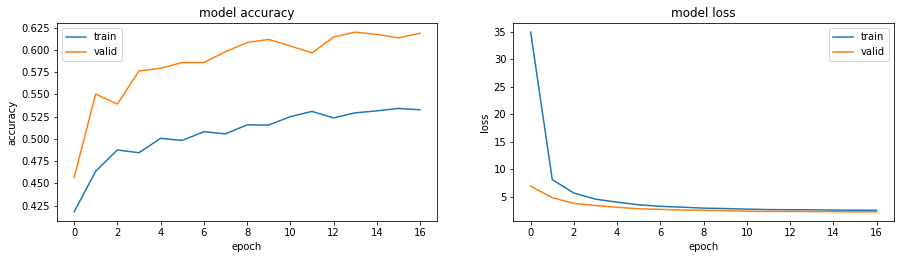


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-03 2.00e+00 3.00e-01 3.20e+01 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.45961, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.45961 to 0.49935, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.49935 to 0.52052, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.52052 to 0.53780, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.53780 to 0.54082, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.54082 to 0.54860, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.54860

Epoch 8: val_accuracy improved from 0.54860 to 0.55680, saving model to VGG_16.h5

Epoch 9: val_accuracy did not improve from 0.55680

Epoch 10: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 10: val_accuracy did not improve from 0.55680

Epoch 11: val_accuracy did not improve from 0.55680
Epoch 11: early stopping
73/73 [=================

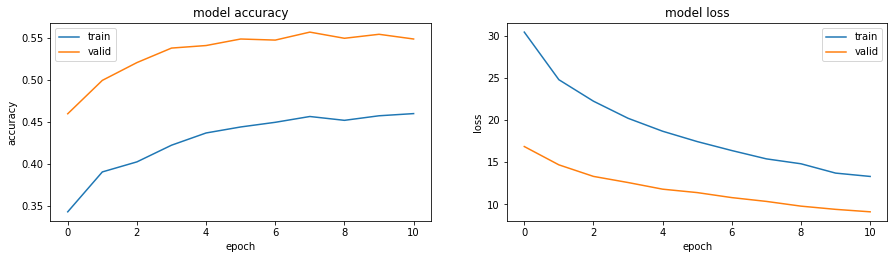


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-03 2.00e+00 3.00e-01 1.28e+02 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.56112, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.56112

Epoch 3: val_accuracy improved from 0.56112 to 0.57149, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.57149 to 0.59179, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.59179

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 6: val_accuracy did not improve from 0.59179

Epoch 7: val_accuracy did not improve from 0.59179
Epoch 7: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 2.4225 - accuracy: 0.5741 - precision_m: 0.5943 - recall_m: 0.5468 - f1_m: 0.5691

LOSS:	2.4225409030914307 	 ACCURACY:	0.57408207654953 	 PRECISION:	0.5943325757980347 	 RECALL:	0.5468166470527649 	 F1-SCORE:	0.5691352486610413
[2.4225409030914307, 0.57408207654953, 0.5943325757980347, 0.546816647

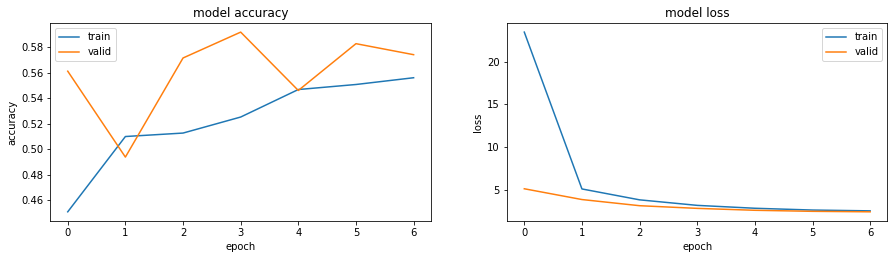


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-03 1.00e+00 7.00e-01 1.28e+02 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.36415, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.36415 to 0.43715, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.43715 to 0.47775, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.47775 to 0.49849, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.49849 to 0.51058, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.51058 to 0.51620, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.51620 to 0.52484, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.52484 to 0.53132, saving model to VGG_16.h5

Epoch 9: val_accuracy did not improve from 0.53132

Epoch 10: val_accuracy improved from 0.53132 to 0.53391, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.53391 to 0.53693, saving model to VGG_16.h5

Epoch 12: val_accuracy improved f

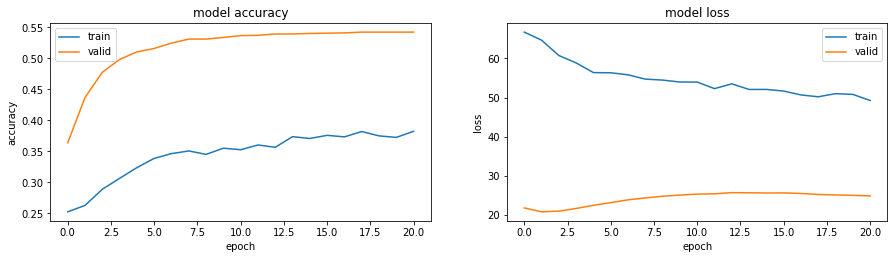


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 2.00e+00 5.00e-01 3.20e+01 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.60000, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.60000

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.60000

Epoch 4: val_accuracy did not improve from 0.60000
Epoch 4: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 2.5087 - accuracy: 0.5888 - precision_m: 0.5990 - recall_m: 0.5627 - f1_m: 0.5800

LOSS:	2.5086510181427 	 ACCURACY:	0.5887688994407654 	 PRECISION:	0.598970890045166 	 RECALL:	0.5627334713935852 	 F1-SCORE:	0.5800073742866516
[2.5086510181427, 0.5887688994407654, 0.598970890045166, 0.5627334713935852, 0.5800073742866516]



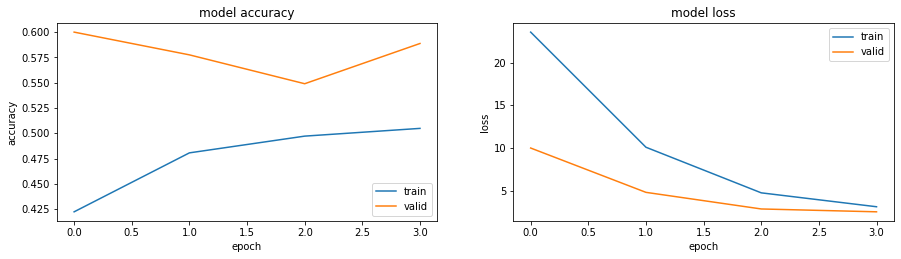


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 1.00e+00 3.00e-01 1.28e+02 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.41857, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.41857 to 0.54600, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.54600 to 0.62549, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.62549

Epoch 5: val_accuracy improved from 0.62549 to 0.63974, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.63974

Epoch 7: val_accuracy improved from 0.63974 to 0.64017, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.64017

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 9: val_accuracy did not improve from 0.64017

Epoch 10: val_accuracy did not improve from 0.64017
Epoch 10: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 1.3934 - accuracy: 0.5676 - precision_m: 0.6527 - recall_m: 0.3432 - f1_m: 0.44

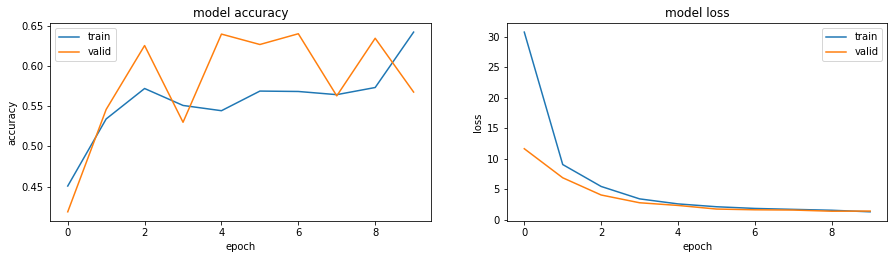


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-03 3.00e+00 5.00e-01 1.28e+02 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.13650, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.13650 to 0.13866, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.13866 to 0.13996, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.13996 to 0.14039, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.14039 to 0.14125, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.14125 to 0.14212, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.14212 to 0.14471, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.14471 to 0.14600, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.14600 to 0.14730, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.14730 to 0.14773, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.14773 to 0.14946, saving model to VGG_16.h5

Ep

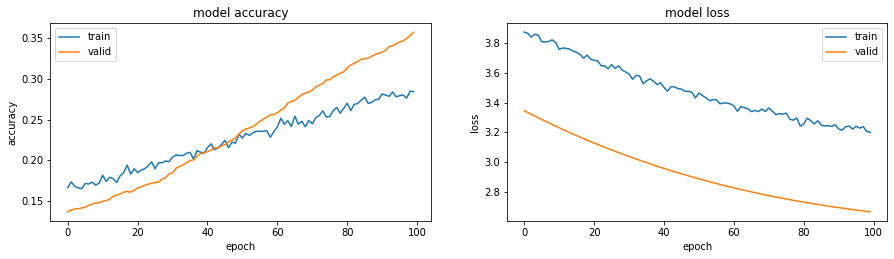


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-03 2.00e+00 3.00e-01 3.20e+01 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.25788, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.25788 to 0.41685, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.41685 to 0.47732, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.47732 to 0.48985, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.48985 to 0.49892, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.49892

Epoch 7: val_accuracy improved from 0.49892 to 0.50929, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.50929

Epoch 9: val_accuracy improved from 0.50929 to 0.50972, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.50972 to 0.51317, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.51317 to 0.51663, saving model to VGG_16.h5

Epoch 12: val_accuracy improved from 0.51663 to 0.52095, saving 

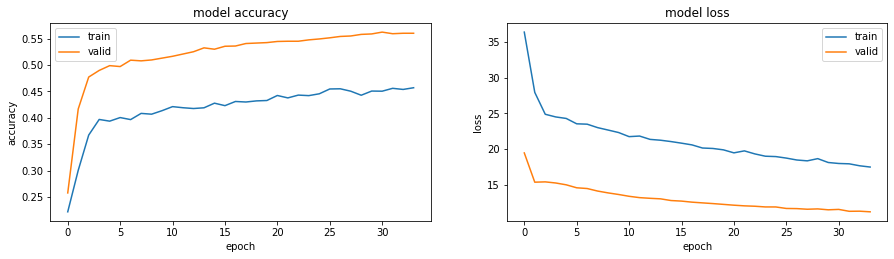


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-02 3.00e+00 3.00e-01 1.28e+02 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.08812, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.08812

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.08812

Epoch 4: val_accuracy did not improve from 0.08812
Epoch 4: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 12.9575 - accuracy: 0.0877 - precision_m: 0.0878 - recall_m: 0.0423 - f1_m: 0.0562

LOSS:	12.957542419433594 	 ACCURACY:	0.08768898248672485 	 PRECISION:	0.08776161074638367 	 RECALL:	0.042341217398643494 	 F1-SCORE:	0.056236837059259415
[12.957542419433594, 0.08768898248672485, 0.08776161074638367, 0.042341217398643494, 0.056236837059259415]



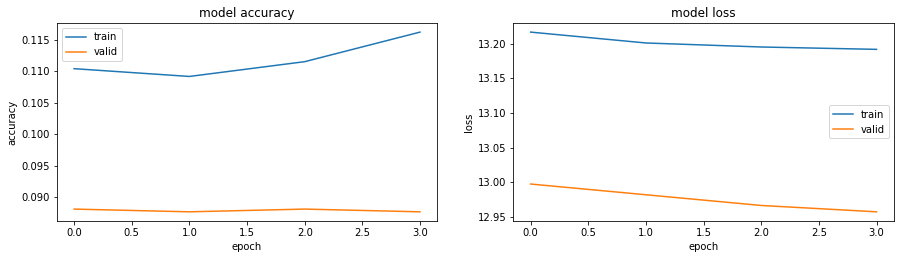


Hyperparameters: [[1.28e+02 1.00e-03 1.00e-02 2.00e+00 5.00e-01 1.28e+02 1.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.58834, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.58834 to 0.61641, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.61641 to 0.61987, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.61987 to 0.62117, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.62117 to 0.62246, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.62246

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 7: val_accuracy did not improve from 0.62246

Epoch 8: val_accuracy did not improve from 0.62246
Epoch 8: early stopping
73/73 [==============================] - 0s 2ms/step - loss: 2.6190 - accuracy: 0.6216 - precision_m: 0.6241 - recall_m: 0.6201 - f1_m: 0.6220

LOSS:	2.6190338134765625 	 ACCURACY:	0.6215982437133789 	 PRECISION:	0.6240851879119873 	 RECALL:	0.62

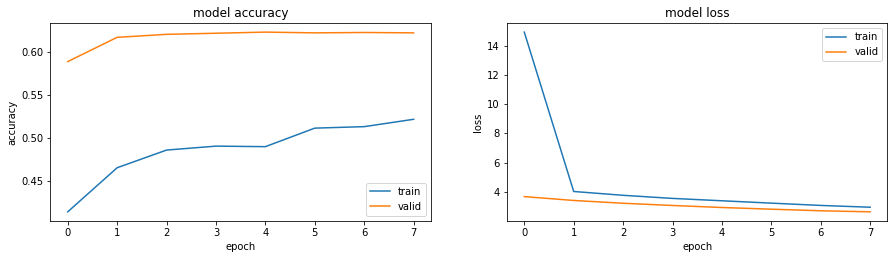


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-02 2.00e+00 7.00e-01 1.28e+02 1.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.29417, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.29417 to 0.30842, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.30842 to 0.32916, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.32916 to 0.34860, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.34860 to 0.35983, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.35983 to 0.37451, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.37451 to 0.39179, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.39179 to 0.40518, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.40518 to 0.41555, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.41555 to 0.42981, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.42981 to 0.44104, saving model to VGG_16.h5

Ep

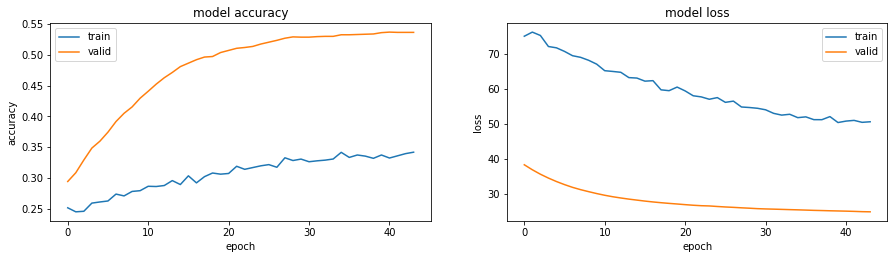


Hyperparameters: [[1.28e+02 1.00e-06 1.00e-01 2.00e+00 7.00e-01 1.28e+02 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.04881, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.04881

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 3: val_accuracy did not improve from 0.04881

Epoch 4: val_accuracy did not improve from 0.04881
Epoch 4: early stopping
73/73 [==============================] - 0s 2ms/step - loss: 139.6892 - accuracy: 0.0488 - precision_m: 0.0484 - recall_m: 0.0484 - f1_m: 0.0484

LOSS:	139.68922424316406 	 ACCURACY:	0.04881209507584572 	 PRECISION:	0.04837328940629959 	 RECALL:	0.04837328940629959 	 F1-SCORE:	0.0483732745051384
[139.68922424316406, 0.04881209507584572, 0.04837328940629959, 0.04837328940629959, 0.0483732745051384]



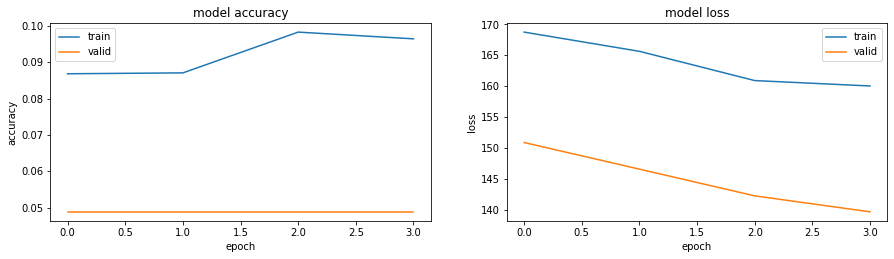


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-02 1.00e+00 3.00e-01 3.20e+01 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.48121, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.48121 to 0.50929, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.50929 to 0.53045, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.53045 to 0.54039, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.54039 to 0.54687, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.54687 to 0.55508, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.55508

Epoch 8: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 8: val_accuracy did not improve from 0.55508

Epoch 9: val_accuracy did not improve from 0.55508
Epoch 9: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 11.7465 - accuracy: 0.5421 - precision_m: 0.5419 - recall_m: 0.5409 - f1_m: 0.5414

LOSS:	11.746546745

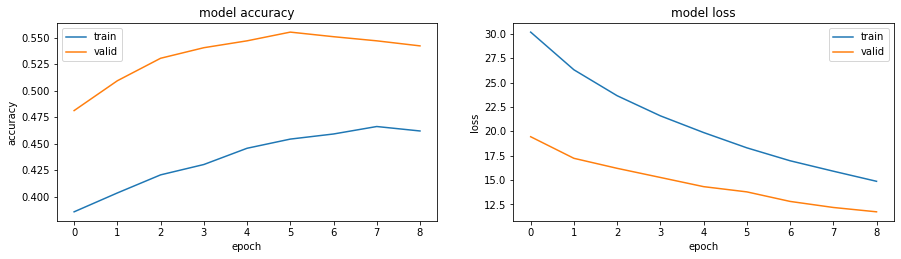


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-03 1.00e+00 5.00e-01 3.20e+01 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.12873, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.12873 to 0.21944, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.21944 to 0.32829, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.32829 to 0.39698, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.39698 to 0.44449, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.44449 to 0.47603, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.47603 to 0.48812, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.48812 to 0.50065, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.50065 to 0.50583, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.50583 to 0.50713, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.50713 to 0.50972, saving model to VGG_16.h5

Ep

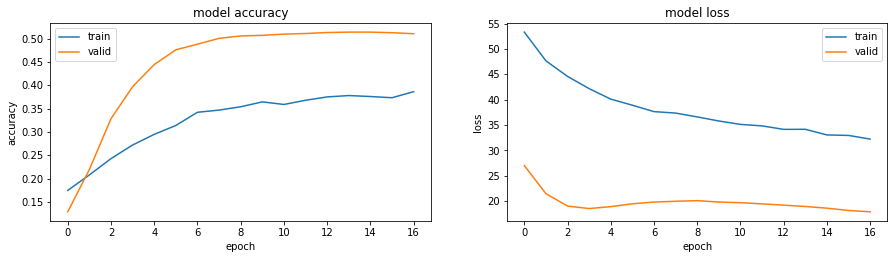


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-01 3.00e+00 5.00e-01 1.28e+02 1.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.53607, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.53607 to 0.56242, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.56242 to 0.57019, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.57019 to 0.58229, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.58229 to 0.60562, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.60562 to 0.60734, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.60734 to 0.61296, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.61296

Epoch 9: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 9: val_accuracy did not improve from 0.61296

Epoch 10: val_accuracy improved from 0.61296 to 0.61641, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.61641 to 0.62203, saving model t

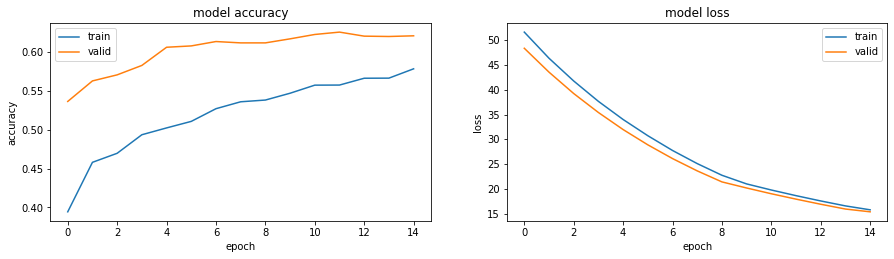


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-02 1.00e+00 7.00e-01 3.20e+01 1.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.59222, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.59222 to 0.60950, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.60950 to 0.61944, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.61944

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.61944

Epoch 6: val_accuracy improved from 0.61944 to 0.62289, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.62289

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 8: val_accuracy did not improve from 0.62289

Epoch 9: val_accuracy did not improve from 0.62289
Epoch 9: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 2.1131 - accuracy: 0.6220 - precision_m: 0.6693 - recall_m: 0.5708 - f1_m: 0.6153

LOSS

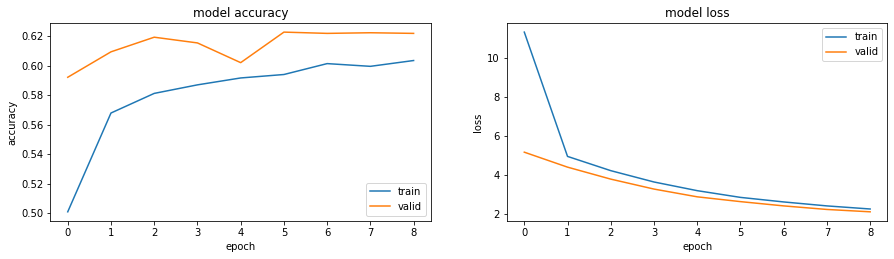


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-03 3.00e+00 5.00e-01 3.20e+01 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.43715, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.43715 to 0.51058, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.51058 to 0.51836, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.51836 to 0.52268, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.52268 to 0.52873, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.52873 to 0.53132, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.53132 to 0.53780, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.53780

Epoch 9: val_accuracy improved from 0.53780 to 0.54384, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.54384 to 0.55248, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.55248 to 0.55335, saving model to VGG_16.h5

Epoch 12: val_accuracy improved f

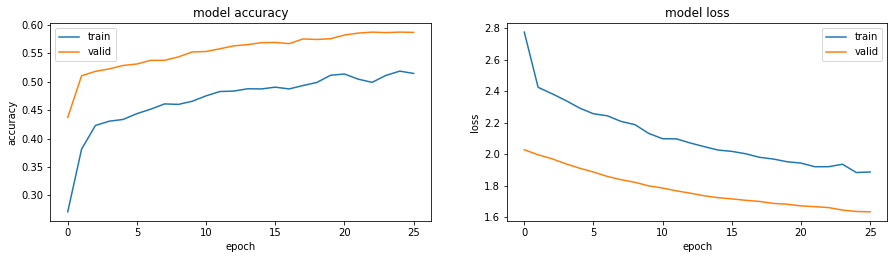


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-02 1.00e+00 3.00e-01 3.20e+01 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.48423, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.48423 to 0.54255, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.54255 to 0.55292, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.55292

Epoch 5: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 5: val_accuracy did not improve from 0.55292

Epoch 6: val_accuracy improved from 0.55292 to 0.56285, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.56285

Epoch 8: ReduceLROnPlateau reducing learning rate to 3.599999909056351e-05.

Epoch 8: val_accuracy did not improve from 0.56285

Epoch 9: val_accuracy did not improve from 0.56285
Epoch 9: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 6.6982 - accuracy: 0.5577 - precision_m: 0.5779 - recall_m: 0.5186 - f1_m: 0.5461

LOSS

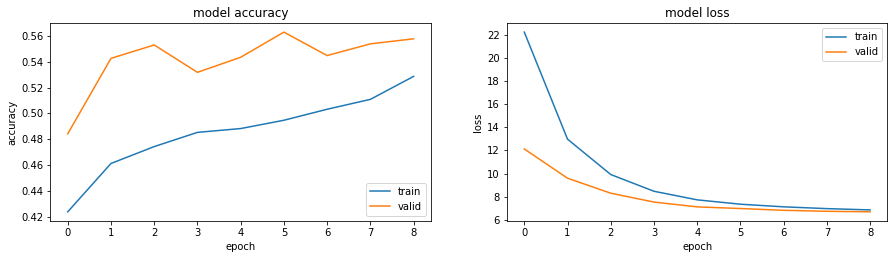


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-02 1.00e+00 5.00e-01 1.28e+02 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.05054, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.05054 to 0.05097, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.05097 to 0.05443, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.05443 to 0.05572, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.05572 to 0.05745, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.05745 to 0.06220, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.06220 to 0.06652, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.06652 to 0.06825, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.06825 to 0.07775, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.07775 to 0.08510, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.08510 to 0.09244, saving model to VGG_16.h5

Ep

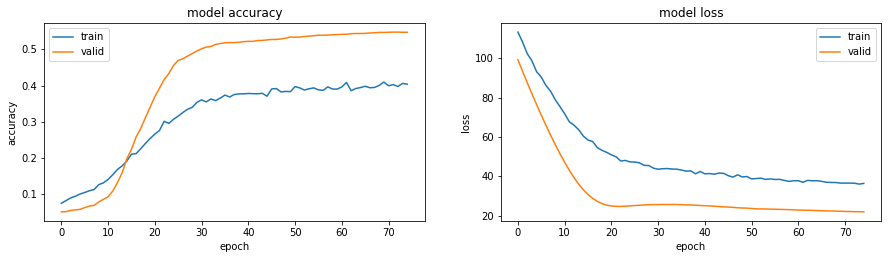


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-03 2.00e+00 3.00e-01 3.20e+01 1.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.11533, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.11533 to 0.21685, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.21685 to 0.31879, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.31879 to 0.37408, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.37408 to 0.42333, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.42333 to 0.45140, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.45140 to 0.46955, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.46955 to 0.47473, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.47473 to 0.47991, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.47991 to 0.48726, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.48726 to 0.48812, saving model to VGG_16.h5

Ep

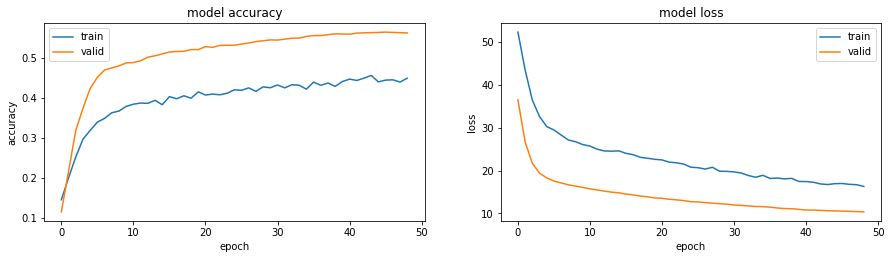


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-03 2.00e+00 5.00e-01 1.28e+02 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.56069, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.56069 to 0.56890, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.56890

Epoch 4: val_accuracy improved from 0.56890 to 0.57192, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.57192 to 0.58272, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.58272 to 0.59136, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.59136 to 0.59741, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.59741 to 0.60432, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.60432 to 0.60994, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.60994 to 0.61641, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.61641 to 0.61987, saving model to VGG_16.h5

Epoch 12: val_accuracy improved f

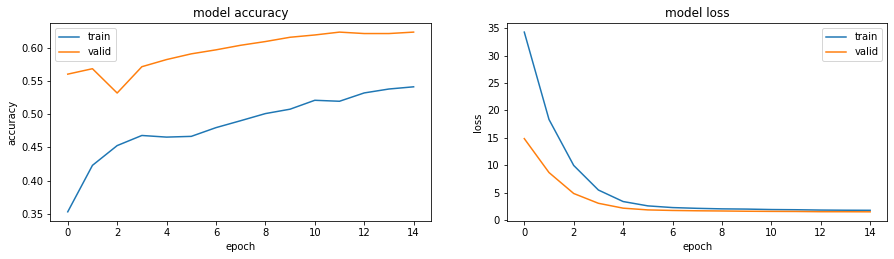


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-02 1.00e+00 3.00e-01 3.20e+01 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.46566, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.46566 to 0.48596, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.48596 to 0.50583, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.50583 to 0.52138, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.52138 to 0.53348, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.53348 to 0.54039, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.54039

Epoch 8: val_accuracy improved from 0.54039 to 0.55032, saving model to VGG_16.h5

Epoch 9: val_accuracy did not improve from 0.55032

Epoch 10: val_accuracy improved from 0.55032 to 0.55248, saving model to VGG_16.h5

Epoch 11: val_accuracy did not improve from 0.55248

Epoch 12: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 12: val_acc

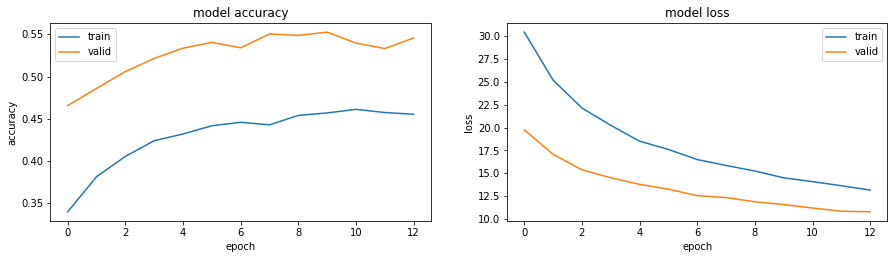


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-02 2.00e+00 3.00e-01 3.20e+01 1.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.55076, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.55076

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.55076

Epoch 4: val_accuracy did not improve from 0.55076
Epoch 4: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 6.5469 - accuracy: 0.5395 - precision_m: 0.5572 - recall_m: 0.4998 - f1_m: 0.5265

LOSS:	6.546929359436035 	 ACCURACY:	0.5395248532295227 	 PRECISION:	0.5572210550308228 	 RECALL:	0.49984434247016907 	 F1-SCORE:	0.5264523029327393
[6.546929359436035, 0.5395248532295227, 0.5572210550308228, 0.49984434247016907, 0.5264523029327393]



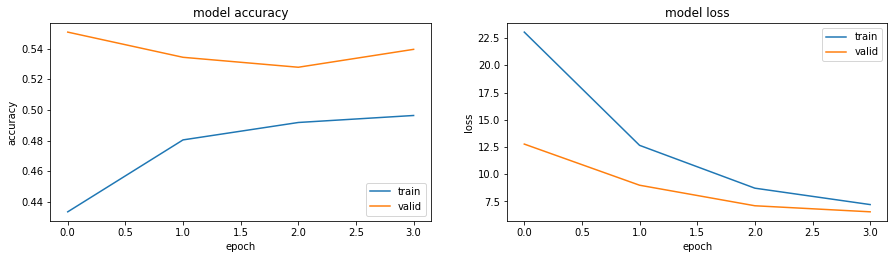


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-03 3.00e+00 5.00e-01 1.28e+02 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.14471, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.14471 to 0.14816, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.14816 to 0.15032, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.15032 to 0.15248, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.15248 to 0.15508, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.15508 to 0.16156, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.16156 to 0.17149, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.17149 to 0.18272, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.18272 to 0.19482, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.19482 to 0.20864, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.20864 to 0.21901, saving model to VGG_16.h5

Ep

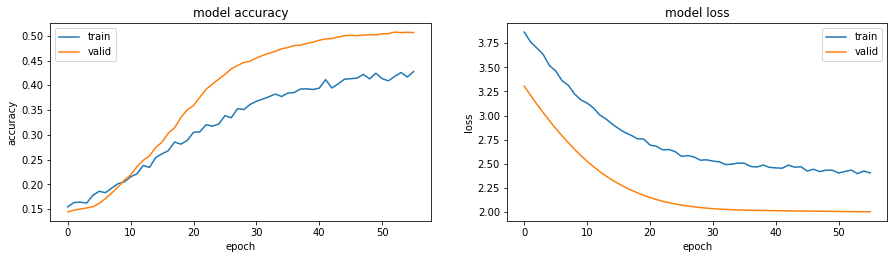


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-03 2.00e+00 5.00e-01 1.28e+02 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.47689, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.47689 to 0.51058, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.51058 to 0.51793, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.51793 to 0.53045, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.53045 to 0.53391, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.53391 to 0.54298, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.54298 to 0.55119, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.55119 to 0.55940, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.55940 to 0.56674, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.56674 to 0.56760, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.56760 to 0.56803, saving model to VGG_16.h5

Ep

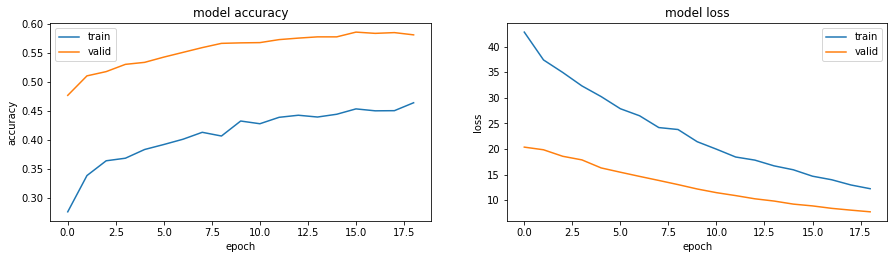


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-02 2.00e+00 7.00e-01 1.28e+02 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.49158, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.49158 to 0.52873, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.52873

Epoch 4: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 4: val_accuracy did not improve from 0.52873

Epoch 5: val_accuracy improved from 0.52873 to 0.52959, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.52959 to 0.53002, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.53002 to 0.53218, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.53218

Epoch 9: ReduceLROnPlateau reducing learning rate to 3.5999998544866682e-06.

Epoch 9: val_accuracy did not improve from 0.53218

Epoch 10: val_accuracy did not improve from 0.53218
Epoch 10: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 2

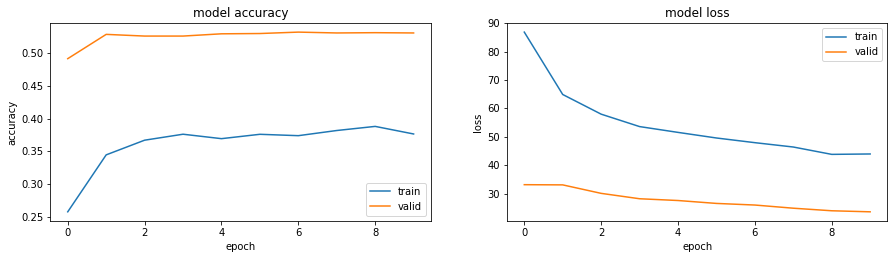


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-01 3.00e+00 7.00e-01 1.28e+02 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.29892, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.29892 to 0.31793, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.31793 to 0.33521, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.33521 to 0.35724, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.35724 to 0.37279, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.37279 to 0.38877, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.38877 to 0.40000, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.40000 to 0.40950, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.40950 to 0.42635, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.42635 to 0.43369, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.43369 to 0.44795, saving model to VGG_16.h5

Ep

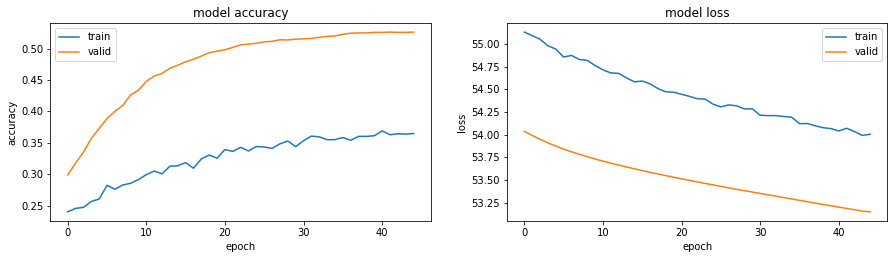


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-03 1.00e+00 5.00e-01 2.56e+02 1.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.52916, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.52916 to 0.56156, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.56156 to 0.57624, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.57624

Epoch 5: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 5: val_accuracy did not improve from 0.57624

Epoch 6: val_accuracy did not improve from 0.57624
Epoch 6: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 5.3436 - accuracy: 0.5490 - precision_m: 0.5503 - recall_m: 0.5490 - f1_m: 0.5496

LOSS:	5.343563079833984 	 ACCURACY:	0.5490280985832214 	 PRECISION:	0.5503078103065491 	 RECALL:	0.5489959716796875 	 F1-SCORE:	0.5496414303779602
[5.343563079833984, 0.5490280985832214, 0.5503078103065491, 0.5489959716796875, 0.5496414303779602]



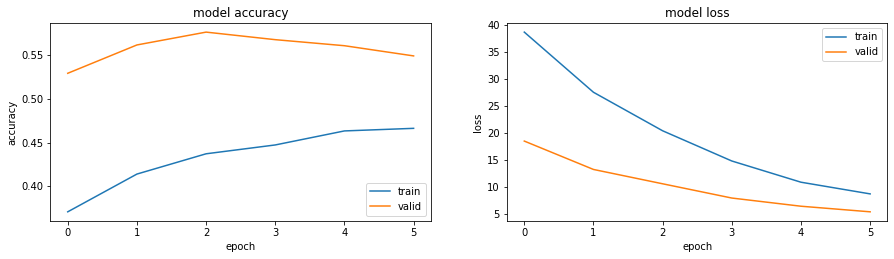


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-02 2.00e+00 3.00e-01 2.56e+02 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.28769, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.28769 to 0.40346, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.40346 to 0.42117, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.42117 to 0.42635, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.42635 to 0.42721, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.42721

Epoch 7: val_accuracy improved from 0.42721 to 0.43369, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.43369 to 0.43629, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.43629 to 0.44276, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.44276 to 0.44924, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.44924 to 0.45356, saving model to VGG_16.h5

Epoch 12: val_accuracy improved f

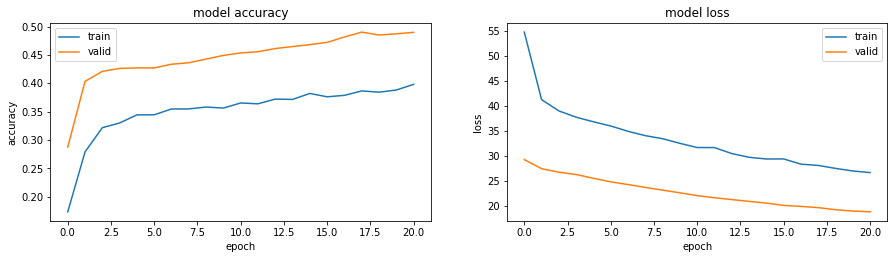


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-03 3.00e+00 7.00e-01 1.28e+02 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.13909, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.13909 to 0.13952, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.13952 to 0.14255, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.14255 to 0.14341, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.14341 to 0.14428, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.14428 to 0.14557, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.14557 to 0.14773, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.14773 to 0.14989, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.14989 to 0.15076, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.15076 to 0.15335, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.15335 to 0.15594, saving model to VGG_16.h5

Ep

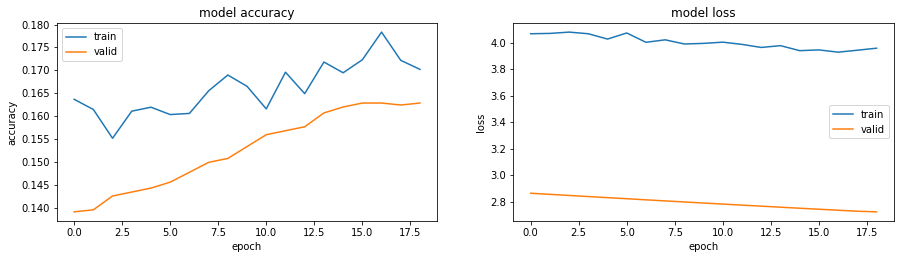


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-01 2.00e+00 7.00e-01 1.28e+02 1.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.08078, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.08078 to 0.08164, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.08164 to 0.08337, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.08337 to 0.08510, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.08510 to 0.08726, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.08726 to 0.08942, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.08942 to 0.09460, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.09460 to 0.09806, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.09806 to 0.10497, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.10497 to 0.11706, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.11706 to 0.12916, saving model to VGG_16.h5

Ep

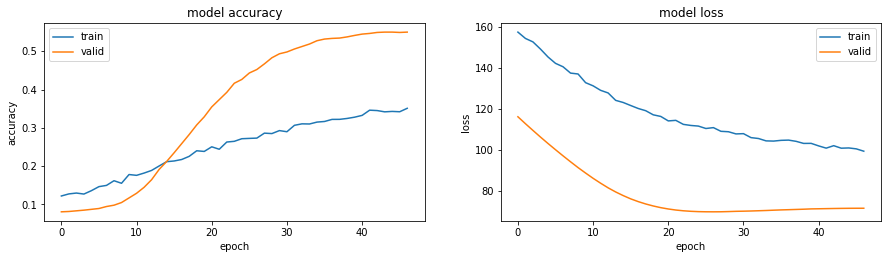


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-02 3.00e+00 3.00e-01 1.28e+02 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.49633, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.49633 to 0.52570, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.52570 to 0.53564, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.53564 to 0.54212, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.54212 to 0.55076, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.55076 to 0.55940, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.55940

Epoch 8: val_accuracy improved from 0.55940 to 0.57667, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.57667 to 0.58359, saving model to VGG_16.h5

Epoch 10: val_accuracy did not improve from 0.58359

Epoch 11: val_accuracy improved from 0.58359 to 0.58618, saving model to VGG_16.h5

Epoch 12: val_accuracy improved from 0.58618 to 0.58877, saving 

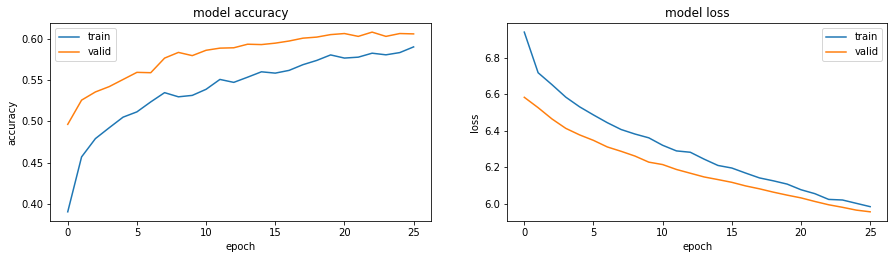


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-01 2.00e+00 7.00e-01 3.20e+01 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.30670, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.30670 to 0.62160, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.62160

Epoch 4: val_accuracy improved from 0.62160 to 0.63283, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.63283

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 6: val_accuracy did not improve from 0.63283

Epoch 7: val_accuracy did not improve from 0.63283
Epoch 7: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 1.1372 - accuracy: 0.6220 - precision_m: 0.6299 - recall_m: 0.6192 - f1_m: 0.6244

LOSS:	1.1372287273406982 	 ACCURACY:	0.6220302581787109 	 PRECISION:	0.6298852562904358 	 RECALL:	0.6192014217376709 	 F1-SCORE:	0.6244139075279236
[1.1372287273406982, 0.6220302581787109, 0.6298852562904358, 0.61920

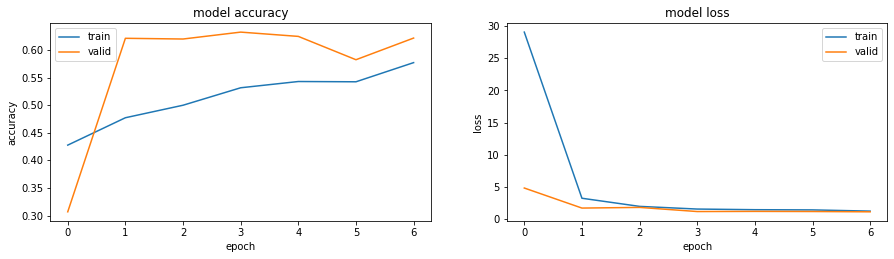


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-02 1.00e+00 5.00e-01 3.20e+01 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.50324, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.50324

Epoch 3: val_accuracy improved from 0.50324 to 0.60734, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.60734 to 0.60907, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.60907 to 0.61598, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.61598 to 0.61987, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.61987

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 8: val_accuracy did not improve from 0.61987

Epoch 9: val_accuracy improved from 0.61987 to 0.62246, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.62246 to 0.62419, saving model to VGG_16.h5

Epoch 11: val_accuracy did not improve from 0.62419

Epoch 12: ReduceLROnPlateau reducing learning rat

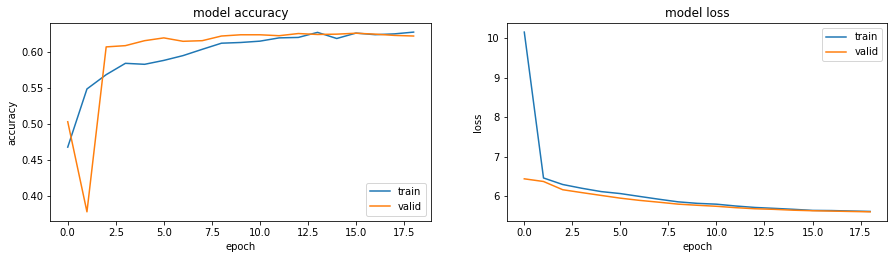


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-03 3.00e+00 7.00e-01 1.28e+02 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.08855, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.08855 to 0.09546, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.09546 to 0.10238, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.10238 to 0.11145, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.11145 to 0.12052, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.12052 to 0.13175, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.13175 to 0.14039, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.14039 to 0.15335, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.15335 to 0.16631, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.16631 to 0.17451, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.17451 to 0.18402, saving model to VGG_16.h5

Ep

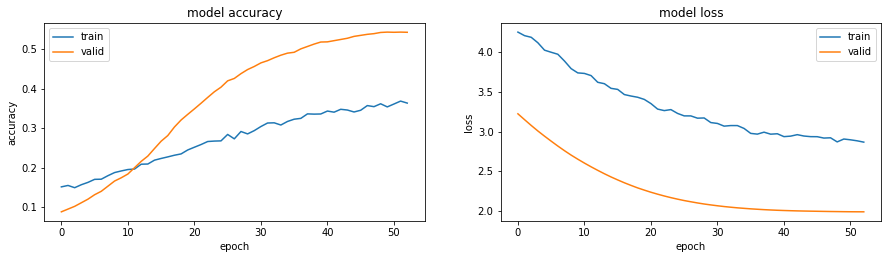


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-01 1.00e+00 5.00e-01 2.56e+02 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.53045, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.53045 to 0.55076, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.55076 to 0.55205, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.55205 to 0.55508, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.55508 to 0.56112, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.56112

Epoch 7: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 7: val_accuracy did not improve from 0.56112

Epoch 8: val_accuracy did not improve from 0.56112
Epoch 8: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 58.5132 - accuracy: 0.5516 - precision_m: 0.5527 - recall_m: 0.5520 - f1_m: 0.5523

LOSS:	58.513187408447266 	 ACCURACY:	0.5516198873519897 	 PRECISION:	0.5526993274688721 	 RECALL:	0.5

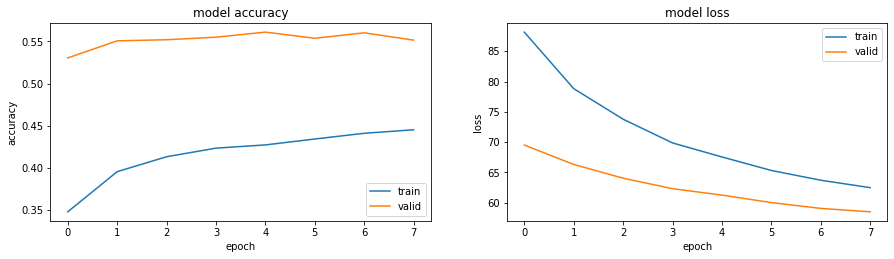


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-03 1.00e+00 5.00e-01 2.56e+02 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.52786, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.52786 to 0.56242, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.56242 to 0.56501, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.56501

Epoch 5: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 5: val_accuracy did not improve from 0.56501

Epoch 6: val_accuracy did not improve from 0.56501
Epoch 6: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 9.2308 - accuracy: 0.5590 - precision_m: 0.5609 - recall_m: 0.5592 - f1_m: 0.5600

LOSS:	9.230830192565918 	 ACCURACY:	0.5589632987976074 	 PRECISION:	0.5608816742897034 	 RECALL:	0.5592310428619385 	 F1-SCORE:	0.5600378513336182
[9.230830192565918, 0.5589632987976074, 0.5608816742897034, 0.5592310428619385, 0.5600378513336182]



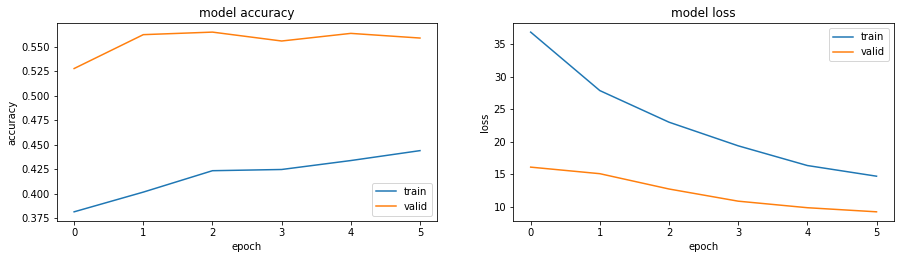


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-02 2.00e+00 3.00e-01 2.56e+02 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.11577, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.11577 to 0.12225, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.12225 to 0.13045, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.13045 to 0.13909, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.13909 to 0.15335, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.15335 to 0.16587, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.16587 to 0.18315, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.18315 to 0.20043, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.20043 to 0.21901, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.21901 to 0.23456, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.23456 to 0.25054, saving model to VGG_16.h5

Ep

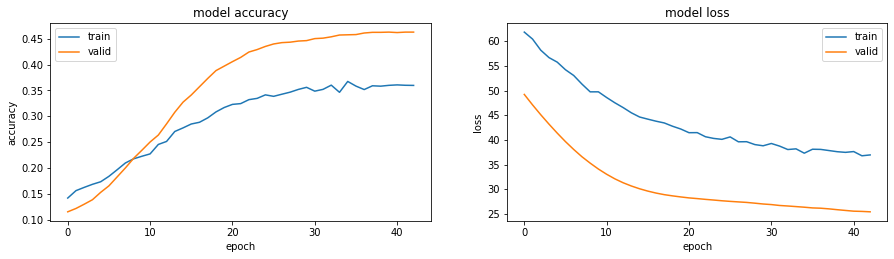


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-02 2.00e+00 5.00e-01 3.20e+01 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.55724, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.55724 to 0.55810, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.55810 to 0.58359, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.58359 to 0.60691, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.60691 to 0.61296, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.61296 to 0.62030, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.62030

Epoch 8: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 8: val_accuracy did not improve from 0.62030

Epoch 9: val_accuracy improved from 0.62030 to 0.62721, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.62721 to 0.63110, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.63110 to 0.63283, saving model t

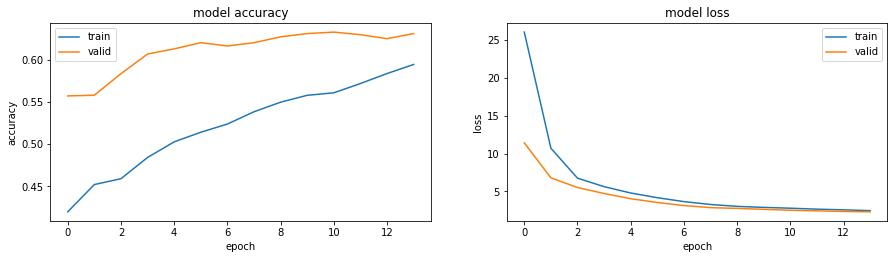


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-02 1.00e+00 7.00e-01 3.20e+01 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.39525, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.39525 to 0.48942, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.48942 to 0.51965, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.51965 to 0.52786, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.52786 to 0.53132, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.53132 to 0.53261, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.53261 to 0.53348, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.53348 to 0.53521, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.53521 to 0.53693, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.53693 to 0.53737, saving model to VGG_16.h5

Epoch 11: val_accuracy did not improve from 0.53737

Epoch 12: ReduceLROnPlateau reduc

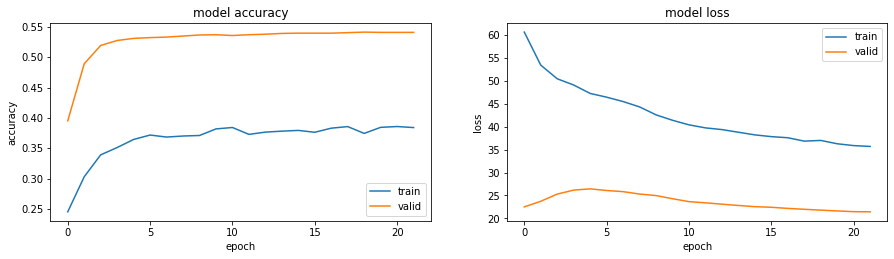


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-01 1.00e+00 5.00e-01 1.28e+02 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.49719, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.49719 to 0.51620, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.51620

Epoch 4: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 4: val_accuracy did not improve from 0.51620

Epoch 5: val_accuracy improved from 0.51620 to 0.52268, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.52268

Epoch 7: val_accuracy improved from 0.52268 to 0.52786, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.52786 to 0.52916, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.52916 to 0.53348, saving model to VGG_16.h5

Epoch 10: val_accuracy did not improve from 0.53348

Epoch 11: val_accuracy improved from 0.53348 to 0.53650, saving model to VGG_16.h5

Epoch 12: val_accuracy improved from 0.53650 to 0

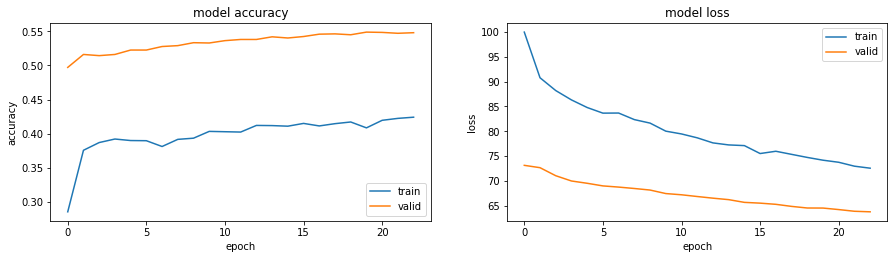


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-02 3.00e+00 3.00e-01 2.56e+02 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.52311, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.52311 to 0.55464, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.55464 to 0.57192, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.57192 to 0.57840, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.57840 to 0.58963, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.58963 to 0.59568, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.59568

Epoch 8: val_accuracy improved from 0.59568 to 0.60605, saving model to VGG_16.h5

Epoch 9: val_accuracy did not improve from 0.60605

Epoch 10: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 10: val_accuracy did not improve from 0.60605

Epoch 11: val_accuracy did not improve from 0.60605
Epoch 11: early stopping
73/73 [=================

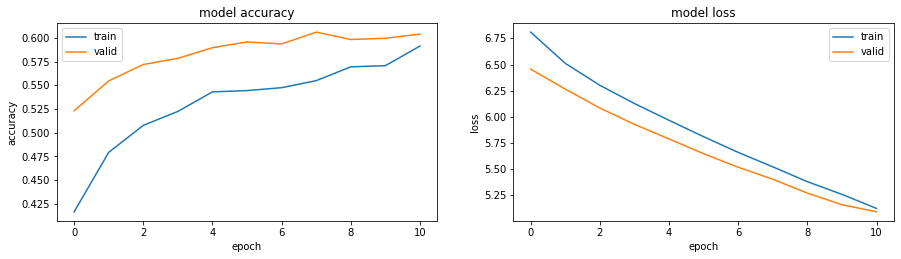


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-02 3.00e+00 7.00e-01 2.56e+02 1.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.27171, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.27171 to 0.32138, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.32138 to 0.37279, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.37279 to 0.41598, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.41598 to 0.45011, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.45011 to 0.47430, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.47430 to 0.48683, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.48683 to 0.49676, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.49676 to 0.49978, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.49978 to 0.50194, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.50194 to 0.50540, saving model to VGG_16.h5

Ep

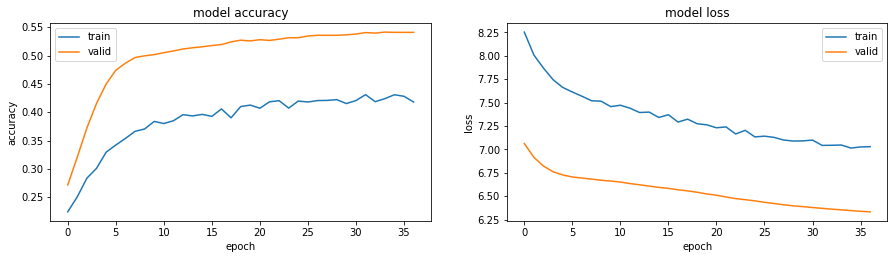


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-03 1.00e+00 3.00e-01 1.28e+02 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.57840, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.57840 to 0.60950, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.60950 to 0.62289, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.62289 to 0.62678, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.62678

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 6: val_accuracy did not improve from 0.62678

Epoch 7: val_accuracy did not improve from 0.62678
Epoch 7: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 1.1451 - accuracy: 0.5991 - precision_m: 0.6864 - recall_m: 0.4467 - f1_m: 0.5394

LOSS:	1.1451059579849243 	 ACCURACY:	0.5991360545158386 	 PRECISION:	0.6863689422607422 	 RECALL:	0.44672319293022156 	 F1-SCORE:	0.5393710732460022
[1.1451059579849243, 0.5991360545158

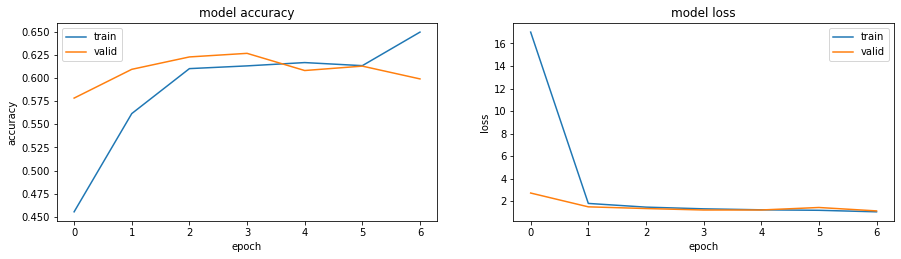


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-01 3.00e+00 7.00e-01 1.28e+02 1.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.61080, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.61080 to 0.61857, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.61857

Epoch 4: val_accuracy improved from 0.61857 to 0.62117, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.62117

Epoch 6: val_accuracy improved from 0.62117 to 0.62203, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.62203

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 8: val_accuracy did not improve from 0.62203

Epoch 9: val_accuracy did not improve from 0.62203
Epoch 9: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 1.1965 - accuracy: 0.6216 - precision_m: 0.6479 - recall_m: 0.5567 - f1_m: 0.5980

LOSS:	1.1965134143829346 	 ACCURACY:	0.6215982437133789 	 PRECISION:	0.6478691101

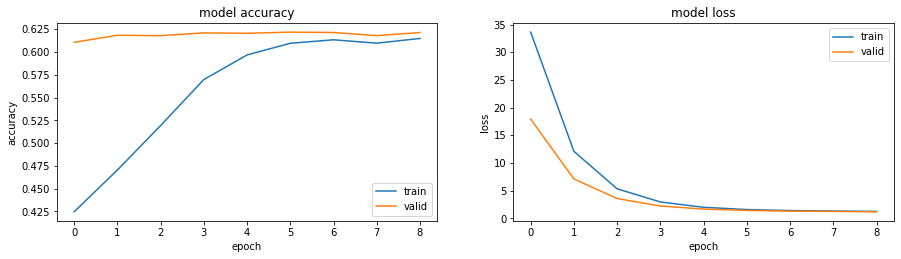


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-03 3.00e+00 3.00e-01 3.20e+01 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.21037, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.21037 to 0.27732, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.27732 to 0.33823, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.33823 to 0.38402, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.38402 to 0.41555, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.41555 to 0.43456, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.43456 to 0.45184, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.45184 to 0.46134, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.46134 to 0.46566, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.46566 to 0.46998, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.46998 to 0.47257, saving model to VGG_16.h5

Ep

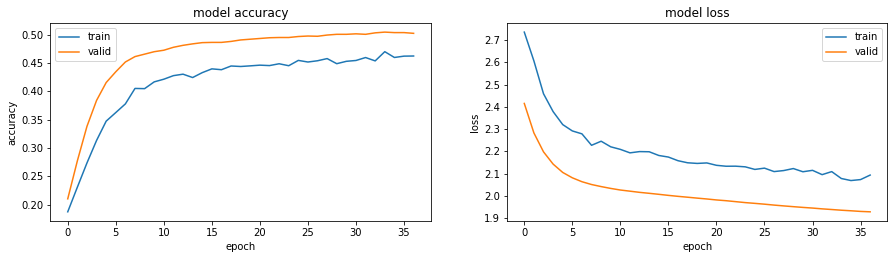


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-01 2.00e+00 5.00e-01 3.20e+01 1.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.56933, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.56933

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.56933

Epoch 4: val_accuracy improved from 0.56933 to 0.58143, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.58143 to 0.59136, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.59136 to 0.60259, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.60259 to 0.60691, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.60691 to 0.61339, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.61339 to 0.61814, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.61814 to 0.62592, saving model to VGG_16.h5

Epoch 11: val_accuracy did not improve from 0.62592

Epoch 12: ReduceLR

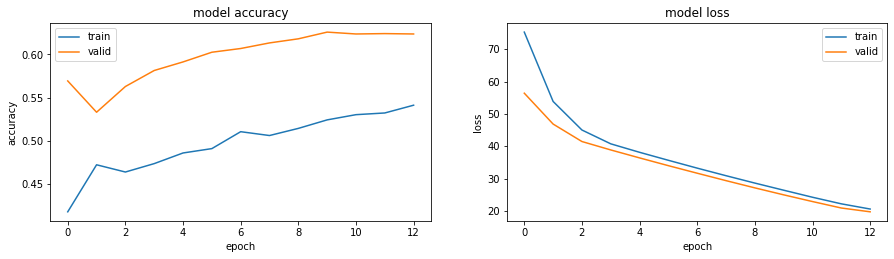


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-03 2.00e+00 3.00e-01 1.28e+02 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.48553, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.48553 to 0.50410, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.50410 to 0.52613, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.52613 to 0.53089, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.53089 to 0.54212, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.54212 to 0.55896, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.55896 to 0.56371, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.56371 to 0.56760, saving model to VGG_16.h5

Epoch 9: val_accuracy did not improve from 0.56760

Epoch 10: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 10: val_accuracy did not improve from 0.56760

Epoch 11: val_accuracy did not improve from 0.56760
Epoch 11: early st

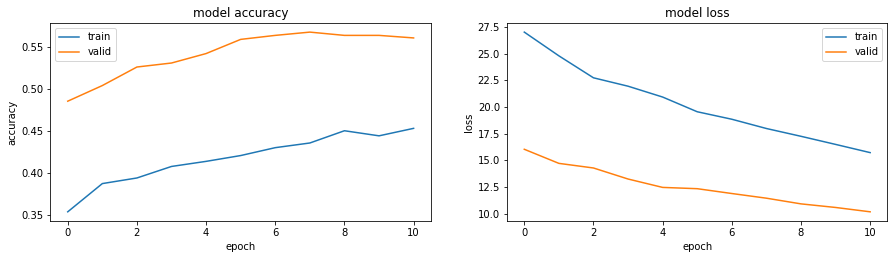


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-02 3.00e+00 5.00e-01 2.56e+02 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.28898, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.28898 to 0.28985, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.28985 to 0.29201, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.29201 to 0.29287, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.29287 to 0.29374, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.29374 to 0.29503, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.29503 to 0.29633, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.29633

Epoch 9: val_accuracy improved from 0.29633 to 0.29719, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.29719 to 0.29762, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.29762 to 0.29849, saving model to VGG_16.h5

Epoch 12: val_accuracy improved f

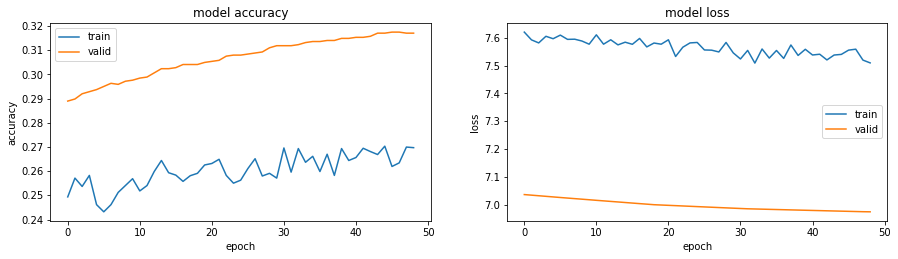


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-02 2.00e+00 5.00e-01 1.28e+02 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.55378, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.55378

Epoch 3: val_accuracy improved from 0.55378 to 0.62851, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.62851

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.62851

Epoch 6: val_accuracy did not improve from 0.62851
Epoch 6: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 1.5113 - accuracy: 0.6130 - precision_m: 0.6377 - recall_m: 0.5606 - f1_m: 0.5959

LOSS:	1.5112907886505127 	 ACCURACY:	0.6129589676856995 	 PRECISION:	0.6376697421073914 	 RECALL:	0.5605542063713074 	 F1-SCORE:	0.5959271192550659
[1.5112907886505127, 0.6129589676856995, 0.6376697421073914, 0.5605542063713074, 0.5959271192550659]



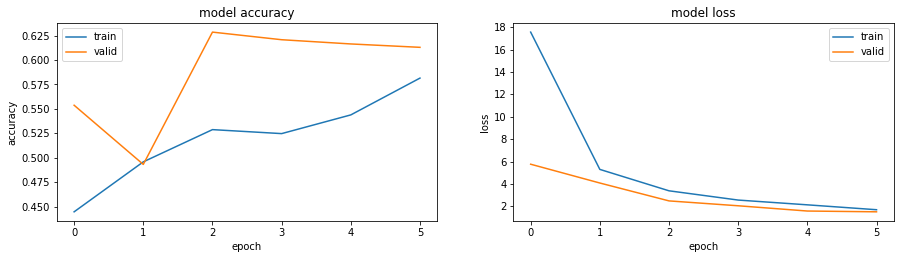


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-01 2.00e+00 5.00e-01 3.20e+01 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.58488, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.58488

Epoch 3: val_accuracy improved from 0.58488 to 0.59309, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.59309 to 0.61253, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.61253 to 0.63067, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.63067

Epoch 7: val_accuracy improved from 0.63067 to 0.63110, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.63110 to 0.63456, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.63456 to 0.63542, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.63542 to 0.63715, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.63715 to 0.64060, saving model to VGG_16.h5

Epoch 12: val_accuracy improved from 0.64060 to 0.64579, saving 

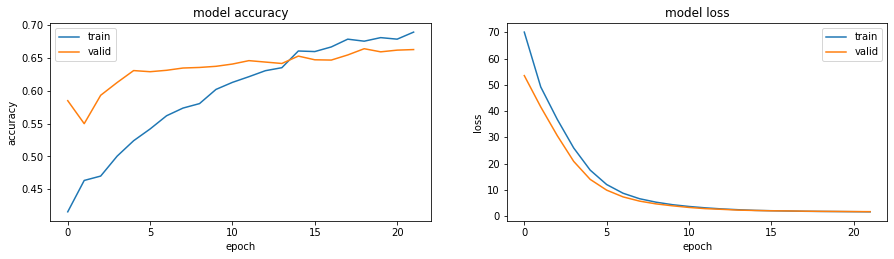


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-03 2.00e+00 3.00e-01 1.28e+02 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.42721, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.42721 to 0.47948, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.47948 to 0.48251, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.48251 to 0.48769, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.48769 to 0.49719, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.49719 to 0.50540, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.50540 to 0.50626, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.50626 to 0.51620, saving model to VGG_16.h5

Epoch 9: val_accuracy did not improve from 0.51620

Epoch 10: val_accuracy improved from 0.51620 to 0.52138, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.52138 to 0.52441, saving model to VGG_16.h5

Epoch 12: val_accuracy did not im

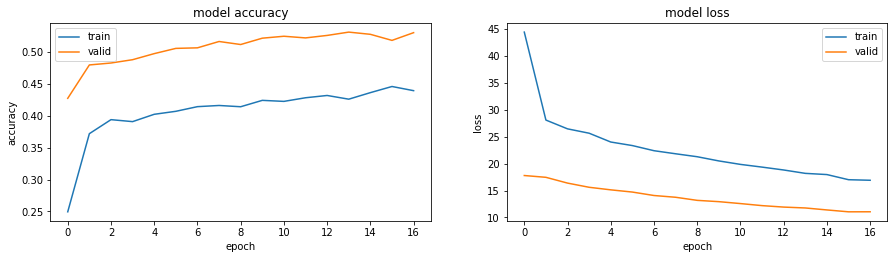


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-02 2.00e+00 5.00e-01 2.56e+02 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.57408, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.57408 to 0.60000, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.60000 to 0.60475, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.60475 to 0.63369, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.63369

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 6: val_accuracy did not improve from 0.63369

Epoch 7: val_accuracy improved from 0.63369 to 0.64060, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.64060

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 9: val_accuracy did not improve from 0.64060

Epoch 10: val_accuracy did not improve from 0.64060
Epoch 10: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 1.

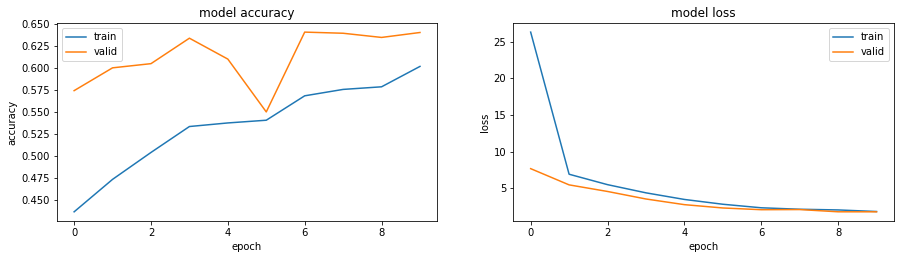


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-02 2.00e+00 7.00e-01 3.20e+01 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.61253, saving model to VGG_16.h5

Epoch 2: val_accuracy did not improve from 0.61253

Epoch 3: val_accuracy improved from 0.61253 to 0.64060, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.64060

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.64060

Epoch 6: val_accuracy did not improve from 0.64060
Epoch 6: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 1.0778 - accuracy: 0.6380 - precision_m: 0.6453 - recall_m: 0.6269 - f1_m: 0.6358

LOSS:	1.0777690410614014 	 ACCURACY:	0.6380129456520081 	 PRECISION:	0.6452980041503906 	 RECALL:	0.6269069314002991 	 F1-SCORE:	0.6358229517936707
[1.0777690410614014, 0.6380129456520081, 0.6452980041503906, 0.6269069314002991, 0.6358229517936707]



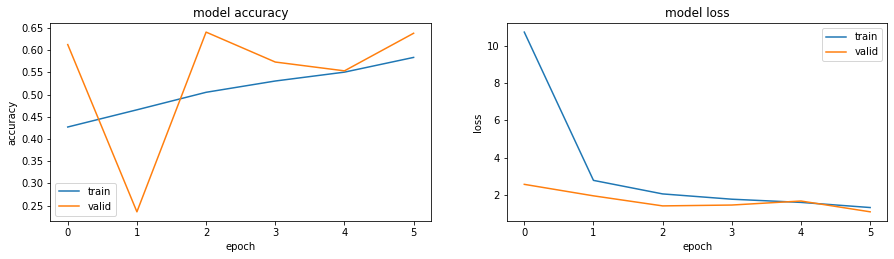


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-02 1.00e+00 5.00e-01 2.56e+02 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.27819, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.27819 to 0.29546, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.29546 to 0.31879, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.31879 to 0.34168, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.34168 to 0.36415, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.36415 to 0.37840, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.37840 to 0.39352, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.39352 to 0.40648, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.40648 to 0.42289, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.42289 to 0.43369, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.43369 to 0.44579, saving model to VGG_16.h5

Ep

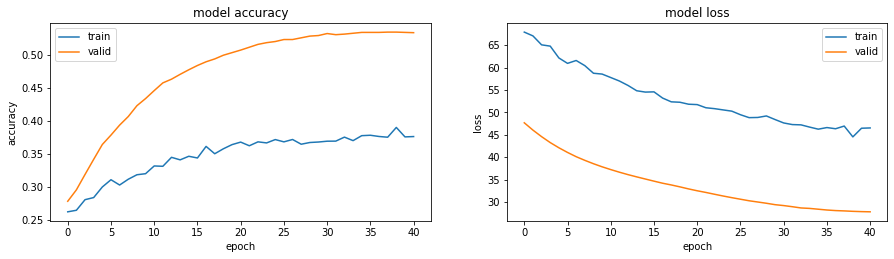


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-02 3.00e+00 5.00e-01 3.20e+01 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.47127, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.47127 to 0.49935, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.49935 to 0.50929, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.50929 to 0.52225, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.52225 to 0.52397, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.52397 to 0.52916, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.52916 to 0.53305, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.53305 to 0.53650, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.53650 to 0.54212, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.54212 to 0.54816, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.54816 to 0.55508, saving model to VGG_16.h5

Ep

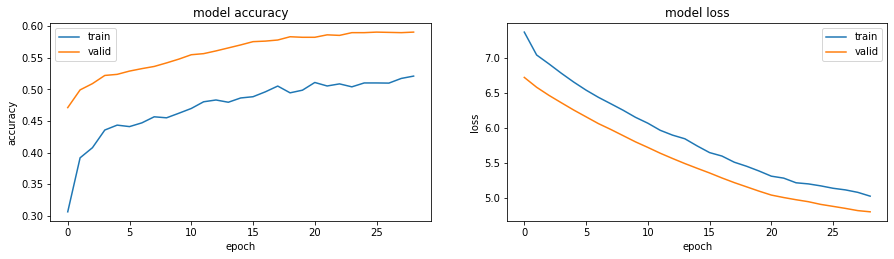


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-03 3.00e+00 5.00e-01 1.28e+02 1.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.51663, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.51663 to 0.56199, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.56199 to 0.57495, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.57495 to 0.60043, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.60043 to 0.60518, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.60518 to 0.60648, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.60648 to 0.60994, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.60994 to 0.61253, saving model to VGG_16.h5

Epoch 9: val_accuracy did not improve from 0.61253

Epoch 10: val_accuracy improved from 0.61253 to 0.61598, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.61598 to 0.62117, saving model to VGG_16.h5

Epoch 12: val_accuracy improved f

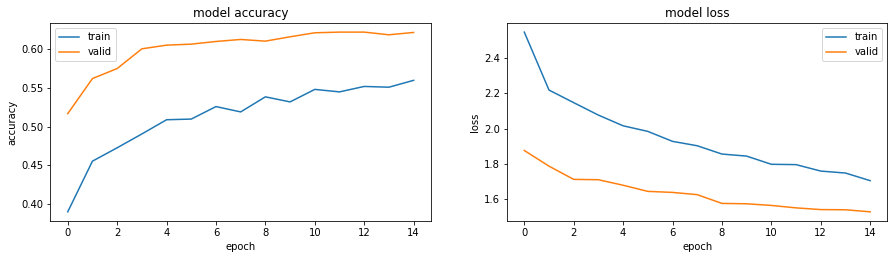


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-01 2.00e+00 5.00e-01 3.20e+01 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.46782, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.46782 to 0.49114, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.49114 to 0.52095, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.52095 to 0.53564, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.53564 to 0.54471, saving model to VGG_16.h5

Epoch 6: val_accuracy did not improve from 0.54471

Epoch 7: val_accuracy improved from 0.54471 to 0.55940, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.55940

Epoch 9: val_accuracy improved from 0.55940 to 0.56544, saving model to VGG_16.h5

Epoch 10: val_accuracy did not improve from 0.56544

Epoch 11: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 11: val_accuracy did not improve from 0.56544

Epoch 12: val_accuracy did not improve from 0.56

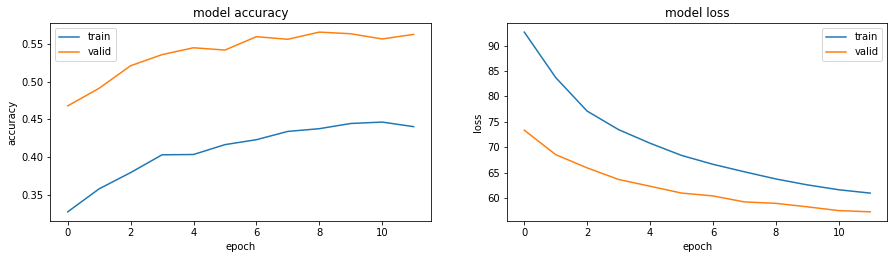


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-03 1.00e+00 7.00e-01 1.28e+02 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.04881, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.04881 to 0.05140, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.05140 to 0.07343, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.07343 to 0.13305, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.13305 to 0.20864, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.20864 to 0.28855, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.28855 to 0.35464, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.35464 to 0.40691, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.40691 to 0.44492, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.44492 to 0.47214, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.47214 to 0.49460, saving model to VGG_16.h5

Ep

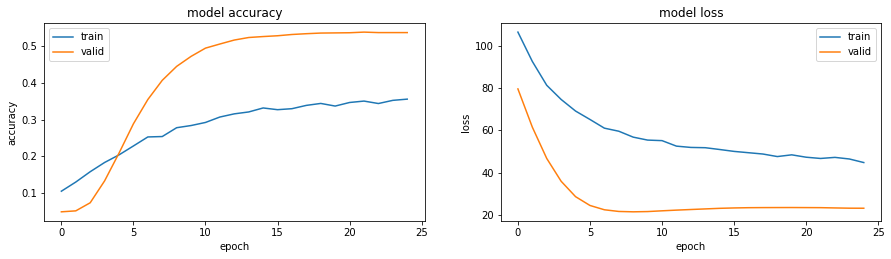


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-03 3.00e+00 3.00e-01 2.56e+02 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.24060, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.24060 to 0.34730, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.34730 to 0.40000, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.40000 to 0.43672, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.43672 to 0.45918, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.45918 to 0.47862, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.47862 to 0.48337, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.48337 to 0.49633, saving model to VGG_16.h5

Epoch 9: val_accuracy did not improve from 0.49633

Epoch 10: val_accuracy improved from 0.49633 to 0.49676, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.49676 to 0.49892, saving model to VGG_16.h5

Epoch 12: val_accuracy improved f

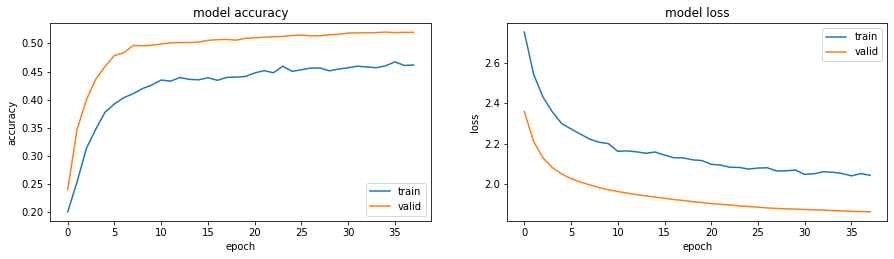


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-03 1.00e+00 7.00e-01 2.56e+02 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.48380, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.48380 to 0.50626, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.50626 to 0.51404, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.51404 to 0.52009, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.52009

Epoch 6: val_accuracy improved from 0.52009 to 0.52225, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.52225

Epoch 8: val_accuracy improved from 0.52225 to 0.52484, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.52484 to 0.52570, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.52570 to 0.52700, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.52700 to 0.52916, saving model to VGG_16.h5

Epoch 12: val_accuracy improved from 0.52916 to 0.53693, saving 

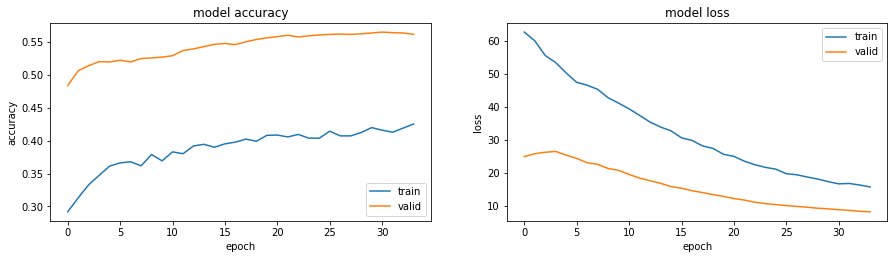


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-03 2.00e+00 7.00e-01 3.20e+01 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.53607, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.53607 to 0.53909, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.53909 to 0.55421, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.55421 to 0.56501, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.56501 to 0.57451, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.57451 to 0.57581, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.57581 to 0.58186, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.58186

Epoch 9: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 9: val_accuracy did not improve from 0.58186

Epoch 10: val_accuracy improved from 0.58186 to 0.58272, saving model to VGG_16.h5

Epoch 11: val_accuracy did not improve from 0.58272

Epoch 12: ReduceLR

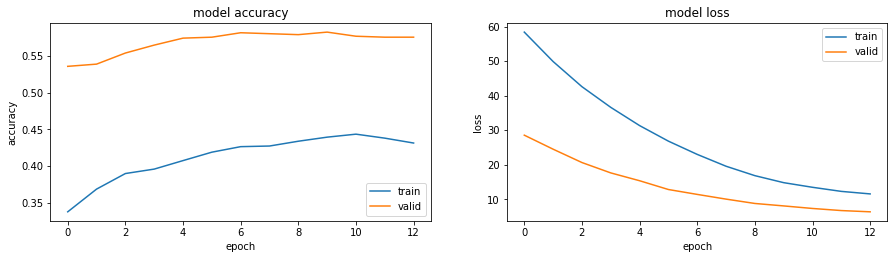


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-03 3.00e+00 5.00e-01 3.20e+01 1.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.57149, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.57149 to 0.58920, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.58920 to 0.60389, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.60389 to 0.60994, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.60994

Epoch 6: val_accuracy improved from 0.60994 to 0.61598, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.61598 to 0.62808, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.62808

Epoch 9: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 9: val_accuracy did not improve from 0.62808

Epoch 10: val_accuracy improved from 0.62808 to 0.63413, saving model to VGG_16.h5

Epoch 11: val_accuracy did not improve from 0.63413

Epoch 12: val_accuracy improved from 0.63413 to 0

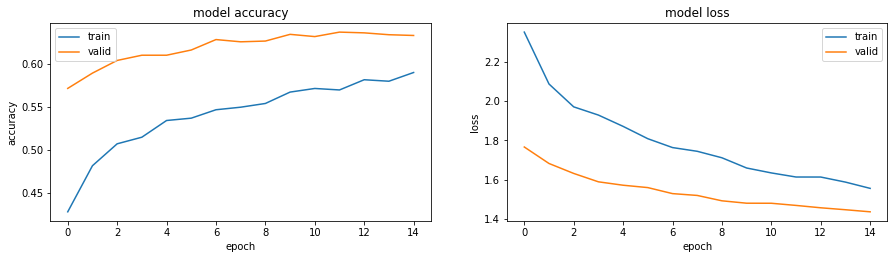


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-03 1.00e+00 5.00e-01 1.28e+02 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.56069, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.56069 to 0.60346, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.60346 to 0.62246, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.62246 to 0.62462, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.62462

Epoch 6: val_accuracy improved from 0.62462 to 0.62808, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.62808 to 0.63240, saving model to VGG_16.h5

Epoch 8: val_accuracy did not improve from 0.63240

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 9: val_accuracy did not improve from 0.63240

Epoch 10: val_accuracy improved from 0.63240 to 0.64104, saving model to VGG_16.h5

Epoch 11: val_accuracy did not improve from 0.64104

Epoch 12: ReduceLROnPlateau reducing learning rat

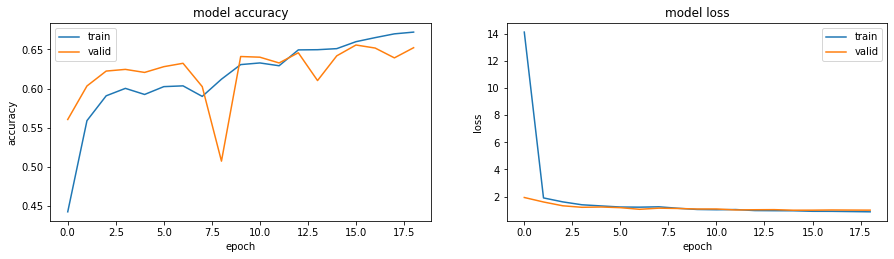


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-03 3.00e+00 7.00e-01 2.56e+02 1.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.06566, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.06566 to 0.08337, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.08337 to 0.13564, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.13564 to 0.19006, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.19006 to 0.25875, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.25875 to 0.33607, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.33607 to 0.40086, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.40086 to 0.44449, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.44449 to 0.47041, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.47041 to 0.48898, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.48898 to 0.50022, saving model to VGG_16.h5

Ep

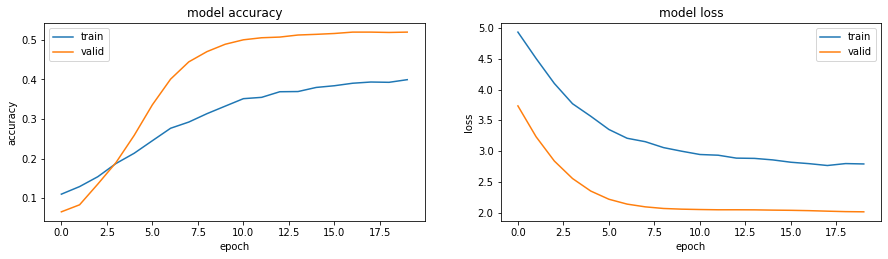


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-03 3.00e+00 3.00e-01 3.20e+01 1.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.61901, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.61901 to 0.62246, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.62246 to 0.62419, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.62419 to 0.62981, saving model to VGG_16.h5

Epoch 5: val_accuracy did not improve from 0.62981

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 6: val_accuracy did not improve from 0.62981

Epoch 7: val_accuracy did not improve from 0.62981
Epoch 7: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 1.1974 - accuracy: 0.6203 - precision_m: 0.6453 - recall_m: 0.5567 - f1_m: 0.5969

LOSS:	1.1973628997802734 	 ACCURACY:	0.6203023791313171 	 PRECISION:	0.6452605128288269 	 RECALL:	0.5567014217376709 	 F1-SCORE:	0.5968729853630066
[1.1973628997802734, 0.62030237913131

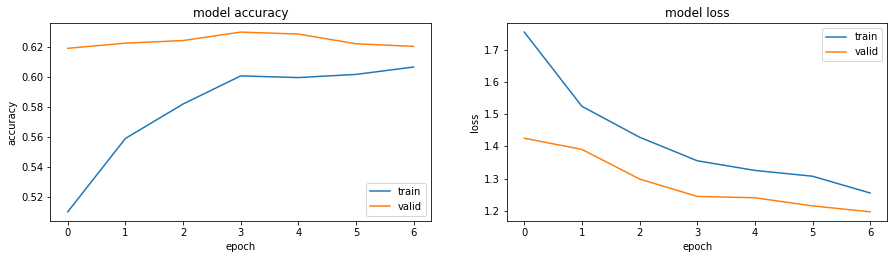


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-03 3.00e+00 3.00e-01 1.28e+02 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.54428, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.54428 to 0.57149, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.57149 to 0.59179, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.59179 to 0.60086, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.60086 to 0.60518, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.60518 to 0.61728, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.61728

Epoch 8: val_accuracy improved from 0.61728 to 0.61987, saving model to VGG_16.h5

Epoch 9: val_accuracy did not improve from 0.61987

Epoch 10: val_accuracy improved from 0.61987 to 0.62203, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.62203 to 0.62808, saving model to VGG_16.h5

Epoch 12: val_accuracy did not improve from 0.62808

Epoch 13: v

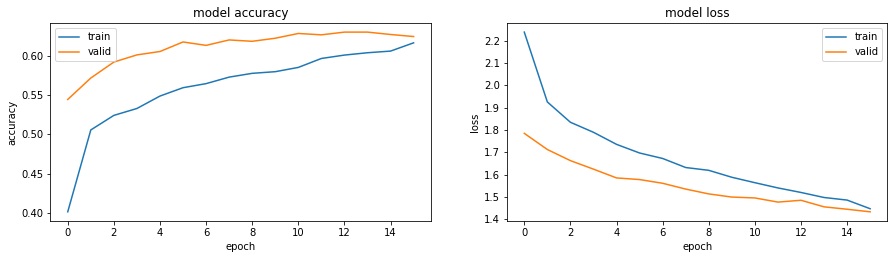


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-02 2.00e+00 3.00e-01 2.56e+02 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.50842, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.50842 to 0.51447, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.51447 to 0.52052, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.52052 to 0.52916, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.52916 to 0.54600, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.54600 to 0.55076, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.55076 to 0.56544, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.56544 to 0.57495, saving model to VGG_16.h5

Epoch 9: val_accuracy did not improve from 0.57495

Epoch 10: val_accuracy improved from 0.57495 to 0.57883, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.57883 to 0.58402, saving model to VGG_16.h5

Epoch 12: val_accuracy improved f

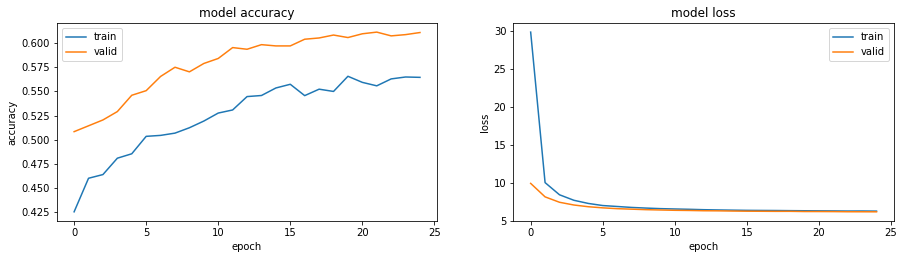


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-03 2.00e+00 5.00e-01 1.28e+02 1.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.59957, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.59957 to 0.61771, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.61771 to 0.62160, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.62160 to 0.62419, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.62419 to 0.62851, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.62851 to 0.63369, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.63369 to 0.63456, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.63456 to 0.63758, saving model to VGG_16.h5

Epoch 9: val_accuracy did not improve from 0.63758

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 10: val_accuracy did not improve from 0.63758

Epoch 11: val_accuracy did not improve from 0.63758
Epoch 11: early st

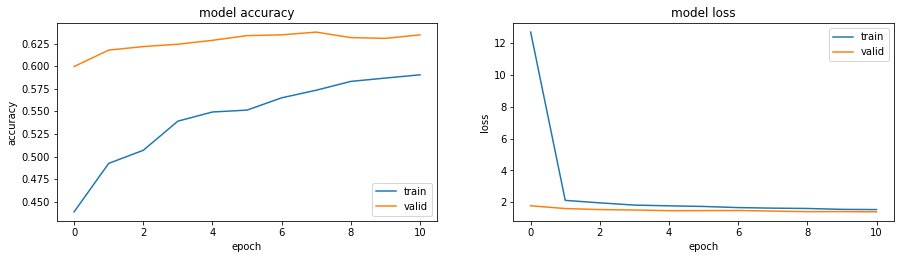


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-03 1.00e+00 5.00e-01 3.20e+01 1.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.46307, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.46307 to 0.48467, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.48467 to 0.49719, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.49719 to 0.50151, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.50151 to 0.50972, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.50972 to 0.51274, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.51274 to 0.51490, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.51490 to 0.52009, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.52009 to 0.52052, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.52052 to 0.52570, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.52570 to 0.52786, saving model to VGG_16.h5

Ep

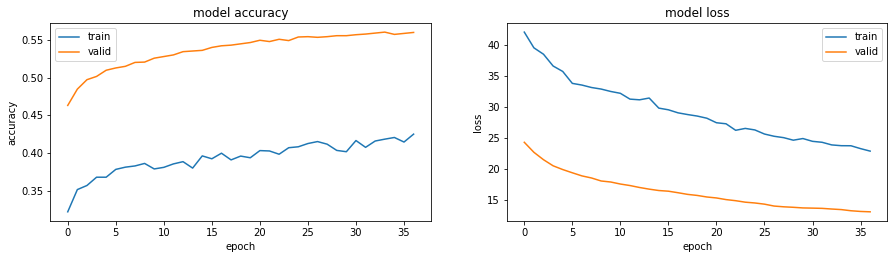


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-01 3.00e+00 5.00e-01 1.28e+02 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.11620, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.11620 to 0.12225, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.12225 to 0.13045, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.13045 to 0.13348, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.13348 to 0.14341, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.14341 to 0.15292, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.15292 to 0.16415, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.16415 to 0.18099, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.18099 to 0.19568, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.19568 to 0.21469, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.21469 to 0.23499, saving model to VGG_16.h5

Ep

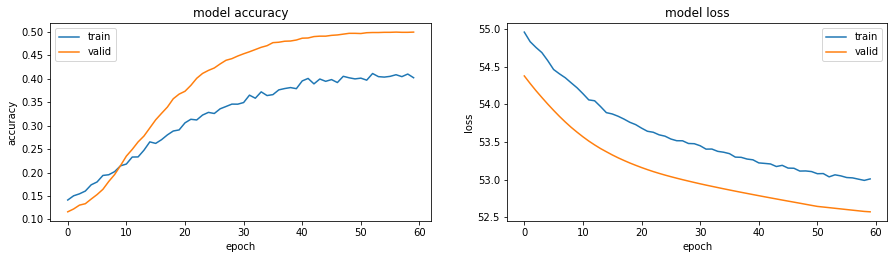


Hyperparameters: [[2.56e+02 1.00e-05 1.00e-02 1.00e+00 5.00e-01 1.28e+02 3.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.36285, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.36285 to 0.48596, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.48596 to 0.50842, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.50842 to 0.52311, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.52311 to 0.53175, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.53175 to 0.53952, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.53952 to 0.54644, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.54644 to 0.55292, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.55292 to 0.56328, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.56328 to 0.57279, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.57279 to 0.57408, saving model to VGG_16.h5

Ep

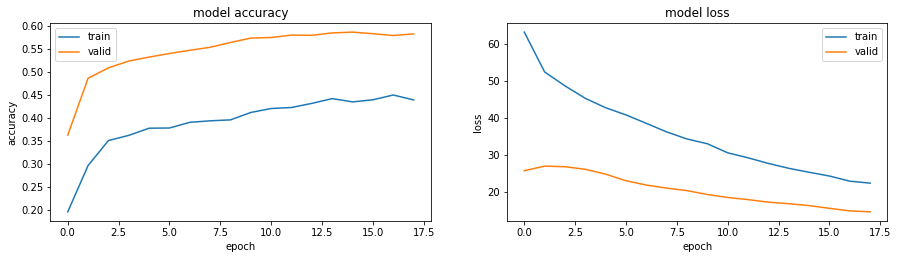


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-03 2.00e+00 7.00e-01 3.20e+01 1.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.18359, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.18359 to 0.18575, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.18575 to 0.19050, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.19050 to 0.20346, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.20346 to 0.22376, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.22376 to 0.28467, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.28467 to 0.34082, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.34082 to 0.39136, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.39136 to 0.42419, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.42419 to 0.44968, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.44968 to 0.47603, saving model to VGG_16.h5

Ep

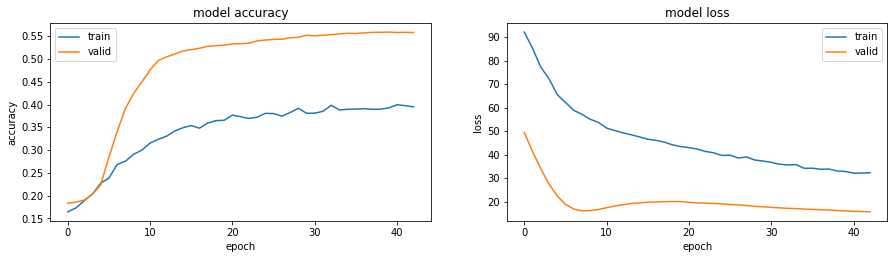


Hyperparameters: [[2.56e+02 1.00e-04 1.00e-03 2.00e+00 3.00e-01 2.56e+02 1.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.53952, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.53952 to 0.56415, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.56415 to 0.56760, saving model to VGG_16.h5

Epoch 4: val_accuracy did not improve from 0.56760

Epoch 5: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 5: val_accuracy did not improve from 0.56760

Epoch 6: val_accuracy did not improve from 0.56760
Epoch 6: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 5.8105 - accuracy: 0.5546 - precision_m: 0.5591 - recall_m: 0.5574 - f1_m: 0.5582

LOSS:	5.81047248840332 	 ACCURACY:	0.5546436309814453 	 PRECISION:	0.5590746402740479 	 RECALL:	0.5574019551277161 	 F1-SCORE:	0.5582209825515747
[5.81047248840332, 0.5546436309814453, 0.5590746402740479, 0.5574019551277161, 0.5582209825515747]



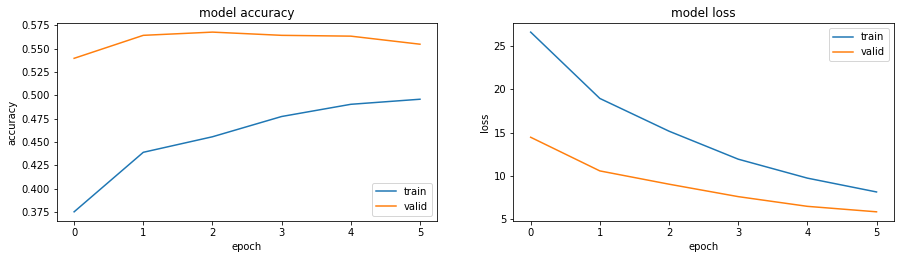


Hyperparameters: [[2.56e+02 1.00e-03 1.00e-02 2.00e+00 5.00e-01 1.28e+02 2.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.53693, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.53693 to 0.58618, saving model to VGG_16.h5

Epoch 3: val_accuracy did not improve from 0.58618

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.58618

Epoch 5: val_accuracy improved from 0.58618 to 0.59438, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.59438 to 0.59914, saving model to VGG_16.h5

Epoch 7: val_accuracy did not improve from 0.59914

Epoch 8: val_accuracy improved from 0.59914 to 0.61253, saving model to VGG_16.h5

Epoch 9: val_accuracy did not improve from 0.61253

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 10: val_accuracy did not improve from 0.61253

Epoch 11: val_accuracy did not improve from 0.61253
Epoch 11: early stopping
73/73 [==

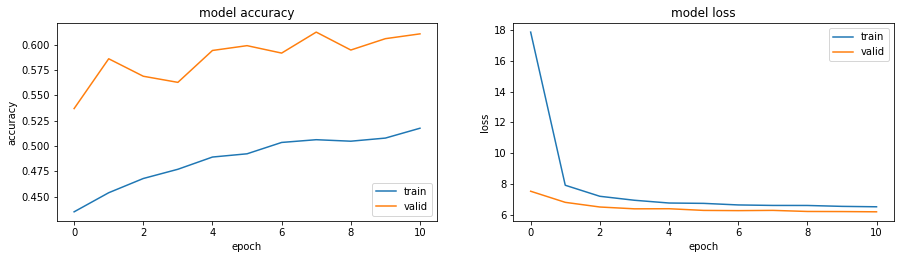


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-01 2.00e+00 7.00e-01 3.20e+01 1.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.17451, saving model to VGG_16.h5

Epoch 2: val_accuracy improved from 0.17451 to 0.18618, saving model to VGG_16.h5

Epoch 3: val_accuracy improved from 0.18618 to 0.23672, saving model to VGG_16.h5

Epoch 4: val_accuracy improved from 0.23672 to 0.30842, saving model to VGG_16.h5

Epoch 5: val_accuracy improved from 0.30842 to 0.38445, saving model to VGG_16.h5

Epoch 6: val_accuracy improved from 0.38445 to 0.43888, saving model to VGG_16.h5

Epoch 7: val_accuracy improved from 0.43888 to 0.47732, saving model to VGG_16.h5

Epoch 8: val_accuracy improved from 0.47732 to 0.50194, saving model to VGG_16.h5

Epoch 9: val_accuracy improved from 0.50194 to 0.51317, saving model to VGG_16.h5

Epoch 10: val_accuracy improved from 0.51317 to 0.52225, saving model to VGG_16.h5

Epoch 11: val_accuracy improved from 0.52225 to 0.52829, saving model to VGG_16.h5

Ep

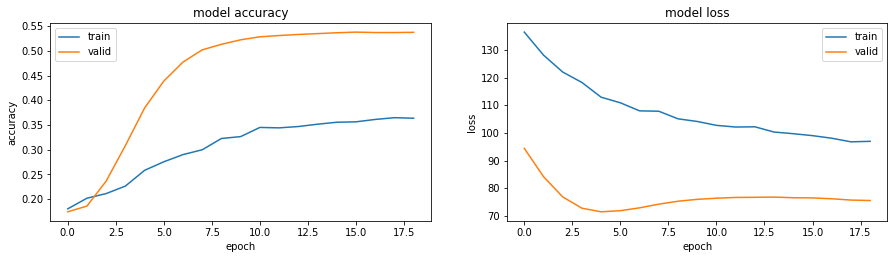

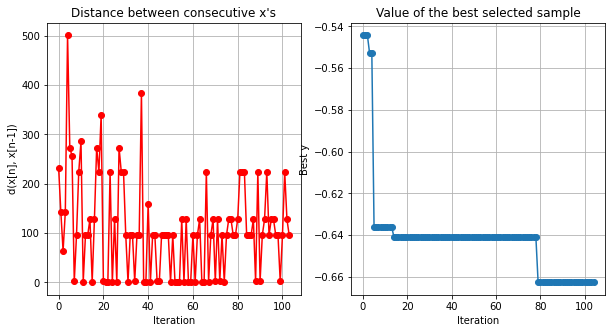

In [ ]:
# define the kernel for the Bayesian surrogate model using the "radial basis function" (RBF)
kernel = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
# hyperparameter bounds
bounds = [{'name': 'units', 'type': 'discrete', 'domain': (64, 128, 256, 512)},
          {'name': 'learning_rate', 'type': 'discrete', 'domain': (1e-3, 1e-4, 1e-5, 1e-6)},
          {'name': 'l2', 'type': 'discrete', 'domain': (1e-1, 1e-2, 1e-3)},
          {'name': 'activation', 'type': 'discrete', 'domain': (1, 2, 3)},
          {'name': 'rate', 'type': 'discrete', 'domain': (0.3, 0.5, 0.7)},
          {'name': 'batch', 'type': 'discrete', 'domain': (32, 128, 256)},
          {'name': 'optim', 'type': 'discrete', 'domain': (1, 2, 3)}]
# Note: 'activation' domain parameters (1, 2, 3) correspond to strings ('relu', 'elu', 'tanh'); dictionary defined in build_model()
# Note: 'optim' domain parameters (1, 2, 3) correspond to strings ('Adam', 'SGD', 'RMSprop'); dictionary defined in build_model()
# objective function for the model optimization:
def f(x):
  """objective function of the Bayesian surrogate model"""
  print()
  print("Hyperparameters:", x)
  # Retrieve 'accuracy' from the previously saved model
  try:
    previous_best_model = K.models.load_model('VGG_16_best.h5')
    previous_evaluation = evaluate_model(previous_best_model)
  except Exception:
    previous_best_model = None
  model, lr_reduce, early_stop, checkpoint, batch = build_model(
                                        units=int(x[:,0]),
                                        learning_rate=float(x[:,1]),
                                        l2=float(x[:,2]),
                                        activation=int(x[:,3]),
                                        rate=float(x[:,4]),
                                        batch=int(x[:,5]),
                                        optim=int(x[:,6]))
  history = fit_model(model, lr_reduce, early_stop, checkpoint, batch)
  evaluation = evaluate_model(model)
  print()
  print("LOSS:\t{0} \t ACCURACY:\t{1}".format(evaluation[0],evaluation[1]))
  #print("LOSS:\t{0} \t ACCURACY:\t{1} \t PRECISION:\t{2} \t RECALL:\t{3} \t F1-SCORE:\t{4}".format(evaluation[0], evaluation[1], evaluation[2], evaluation[3], evaluation[4]))
  print(evaluation)
  print()
  # compare previous and current validation accuracies
  if not previous_best_model:
    K.models.save_model(model, 'VGG_16_best.h5', overwrite=True,
    include_optimizer=True)
  if previous_best_model and evaluation[1] > previous_evaluation[1]:
    K.models.save_model(model, 'VGG_16_best.h5', overwrite=True,
    include_optimizer=True)
  # Get the dictionary containing each metric and the loss for each epoch
  # history_dict = history.history
  # print(history_dict)
  def plot_history(history):
  #function that plots the model loss and accuracy
    plt.figure(1, figsize = (15,8))
    plt.subplot(221)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'])
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'])
    plt.show()
  # plot the model accuracy and loss results
  plot_history(history)
  # delete the instantiated models from memory and clear the session
  del model
  del previous_best_model
  K.backend.clear_session()
  return evaluation[1]
# Initializing X and Y, and adding noise (if need be)
# X_init = np.array([[int(16)]])
# Y_init = f(X_init)
# noise = 0.2
optimizer = BayesianOptimization(f=f,
                                 domain=bounds,
                                 model_type='GP',
                                 kernel=kernel,
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.01,
                                 # X=X_init,
                                 # Y=-Y_init,
                                 # noise_var = noise**2,
                                 exact_feval=False,
                                 normalize_Y=False,
                                 maximize=True,
                                 verbosity=False)
print()
print("=====================")
print("=====================")
print()
optimizer.run_optimization(max_iter=100, verbosity=False)
optimizer.plot_acquisition()
optimizer.plot_convergence()
optimizer.save_report('bayes_opt.txt')

In [ ]:
# print optimized model
activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh'}
optimizer_dict = {1: 'Adam', 2: 'SGD', 3: 'RMSprop'}
print("""
Optimized Parameters:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
""".format(bounds[0]["name"], optimizer.x_opt[0],
           bounds[1]["name"], optimizer.x_opt[1],
           bounds[2]["name"], optimizer.x_opt[2],
           bounds[3]["name"], activation_dict[optimizer.x_opt[3]],
           bounds[4]["name"], optimizer.x_opt[4],
           bounds[5]["name"], optimizer.x_opt[5]),
           bounds[6]["name"], optimizer_dict[optimizer.x_opt[6]])
print("optimized accuracy: {0}".format(abs(optimizer.fx_opt)))


Optimized Parameters:
	units:	256.0
	learning_rate:	0.0001
	l2:	0.1
	activation:	elu
	rate:	0.5
	batch:	32.0
 optim RMSprop
optimized accuracy: [0.66263497]


In [ ]:
# reinstantiate the best model from saved file
best_model = K.models.load_model('VGG_16_best.h5')
best_model.summary()
loss, acc = best_model.evaluate(features_valid, y_test) 
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

In [ ]:
best_model.evaluate(features_valid, y_test)

In [ ]:
#print("LOSS:\t{0} \t ACCURACY:\t{1} \t PRECISION:\t{2} \t RECALL:\t{3} \t F1-SCORE:\t{4}".format(loss, acc, recall, precision, f1_score))

In [ ]:
data_path = 'bayes_opt.txt'
with open(data_path, 'r') as f:
  lines = f.read().split('\n')
for line in lines:
  print(line)

Test model with test data

In [ ]:
#https://stackoverflow.com/questions/55674648/how-to-load-local-dataset-x-y-using-keras-framework
!pip install image-dataset-loader
from image_dataset_loader import load

(x_train, y_train), (x_test, y_test) = load('/content/output/', ['train', 'test'])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#  preprocess the data using the application's preprocess_input method and convert the labels to one-hot encodings
x_test, y_test = preprocess_data(x_test, y_test)

In [ ]:

# repeat the same operation with the test data (here used for test)
test_datagen = K.preprocessing.image.ImageDataGenerator(rescale=1./255)  # no augmentation for test set
test_generator = test_datagen.flow(x_test,
                                 y_test,
                                 batch_size=32,
                                 shuffle=False)
features_test = base_model.predict(test_generator)

In [ ]:
# reinstantiate the best model from saved file
loss, acc = best_model.evaluate(features_test, y_test) 
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

1/1 [==============================] - 0s 50ms/step - loss: 103.7989 - accuracy: 0.3333
Restored model, accuracy: 33.33%


In [ ]:
best_model.evaluate(features_test, y_test)

In [ ]:
#print("LOSS:\t{0} \t ACCURACY:\t{1} \t PRECISION:\t{2} \t RECALL:\t{3} \t F1-SCORE:\t{4}".format(loss, acc, recall, precision, f1_score))